<a href="https://colab.research.google.com/github/utkarsh-k-exp/Forecasting--Principles-and-Practice/blob/master/Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import statsmodels.api as sm
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper Functions

In [338]:
def plot_time_series(ts, xlabel = None, ylabel = None, title = None):
  """
  Function to plot a single time series

  Arguments:
  ts -- a pandas data frame, a time series data

  Returns:
  ts_figure -- an object for time series plot
  """
  fig, ax = plt.subplots()

  plt.style.use("seaborn")

  fig.set_figheight(5)
  fig.set_figwidth(20)

  ax.plot(ts)
  ax.set_xlabel(xlabel, fontsize = 15)
  ax.set_ylabel(ylabel, fontsize = 15)
  ax.set_title(title, fontsize = 15)
  ax.grid(linestyle = "--", color = 'black')

  plt.tight_layout()

  return fig, ax

def box_cox_transformation(ts, lambd):
  """
  Function to implement box cox tranformation on the original scale
  
  Arguments:
  ts -- a pandas time series, a time series data
  lambd -- a parameter for box cox tranformation

  Returns:
  ts_transformed -- a pandas data frame, box cox transformed time series
  """

  if lambd == 0:
    return np.log(ts)
  else:
    return (ts**lambd - 1)/lambd

def reverse_box_cox_tranformation(ts_tranformed, lambd):
  """
  Function takes the transformed data and convert it to the original scale

  Arguments:
  ts_transformed -- a pandas data frame, a time series data scaled based on box_cox transformation formula
  lambd -- a value between 0 and 1, hyper-parameter for transformation

  Returns:
  ts -- a pandas data frame, data scaled to original scale
  """
  if lambd == 0:
    return np.exp(ts_tranformed)
  else:
    return (ts_transformed * lambd + 1)**(1/lambd)

def s_naive_forecast(ts, seasonal_period, horizon_start, horizon_end):
  """
  Function to implement the seasonal naive forecast.

  Arguments:
  ts -- a pandas data frame, a time series data
  seasonal_period -- seasonal period in which the pattern repeats itself. monthly = 12, quarterly = 4, daily = 365 etc.

  Returns:
  
  """
  model = sm.tsa.statespace.SARIMAX(ts, order = (0, 0, 0), seasonal_order=(0, 1, 0, seasonal_period))
  model_fit = model.fit()

  ts_forecasts = model_fit.predict(start = horizon_start, end = horizon_end)
  ts_forecasts = pd.DataFrame(ts_forecasts)

  return ts_forecasts

def naive_forecast(ts):
  """
  Function to implement the naive forecast.

  Arguments:
  ts -- a pandas data frame, a time series data

  Returns:
  model_fit -- a naive model fit on the time series data
  """
  model = sm.tsa.statespace.SARIMAX(ts, order=(0, 0, 0), seasonal_order=(0, 1, 0, 0))
  model_fit = model.fit()

  return model_fit

def accuracy(ts_observations, ts_forecasts):
  """
  Function to compute MAE, RMSE and MAPE.

  Arguments:
  ts_observations -- a pandas data frame, a time seris observations
  ts_forecasts -- a pandas data frame, forecasts for the observations

  Returns:
  MAE -- a scalar, mean absoulte error
  RMSE -- a scalar, root mean squared error
  MAPE -- a scalar, mean absolute percentage error
  """
  forecasts_errors = ts_observations - ts_forecasts

  MAE = np.mean(np.absolute(forecasts_errors))

  RMSE = np.sqrt(np.mean(np.square(forecasts_errors)))

  absolute_percentage_error = np.absolute((forecasts_errors / ts_observations) * 100)

  MAPE = np.mean(absolute_percentage_error)

  return MAE, RMSE, MAPE

def drift_forecast(ts, horizon_start = None, horizon_end = None):
  """
  Function computes the forecast for given horizon using drift method

  Arguments:
  ts_training -- a pandas data frame, a time series data

  Returns:
  ts_forecasts -- a pandas data frame, forecasts for the testing set
  """
  y_t = ts.iloc[-1, :].values
  
  m = (y_t - ts.iloc[0, :].values) / len(ts)
  
  h = np.linspace(horizon_start, horizon_end, horizon_end-horizon_start, dtype = 'int')
  
  ts_forecasts = pd.DataFrame({'value': y_t + m * h}, index = h)
  
  return ts_forecasts

def average_forecasts(ts):
  """
  Function compute the average forecast for the time series data

  Arguments:
  ts -- a pandas data frame, a time series data

  Returns:
  ts_forecasts -- a pandas data frame.
  """
  ts_forecasts = ts.copy()

  for col in ts.columns:
    ts_forecasts[col] = np.mean(ts[col])
  
  return ts_forecasts


# Question: 1
  
For the following series, find an appropriate Box-Cox transformation in order to stabilise the variance.

*   usnetelec
*   usgdp
* mcopper
* enplanements

**1.1 usnetelec**

In [3]:
# usmelec: Electricity monthly total net generation. January 1973 - June 2013

ts_usmelec = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/usmelec.csv", index_col="time")
ts_usmelec.drop("Unnamed: 0", axis = 1, inplace = True)

Plotting the data on the original scale

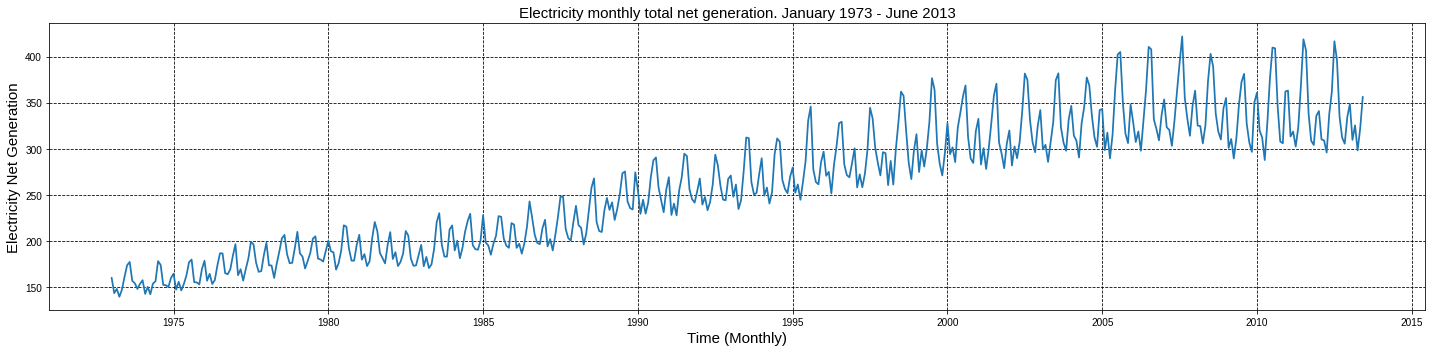

In [4]:
ts_usmelec_fig = plot_time_series(ts_usmelec, xlabel = "Time (Monthly)", ylabel = "Electricity Net Generation", title = "Electricity monthly total net generation. January 1973 - June 2013")

Variance of the data is increasing over time. Let's see the impact of box cox tranformation on the variance

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fab66ac50>)

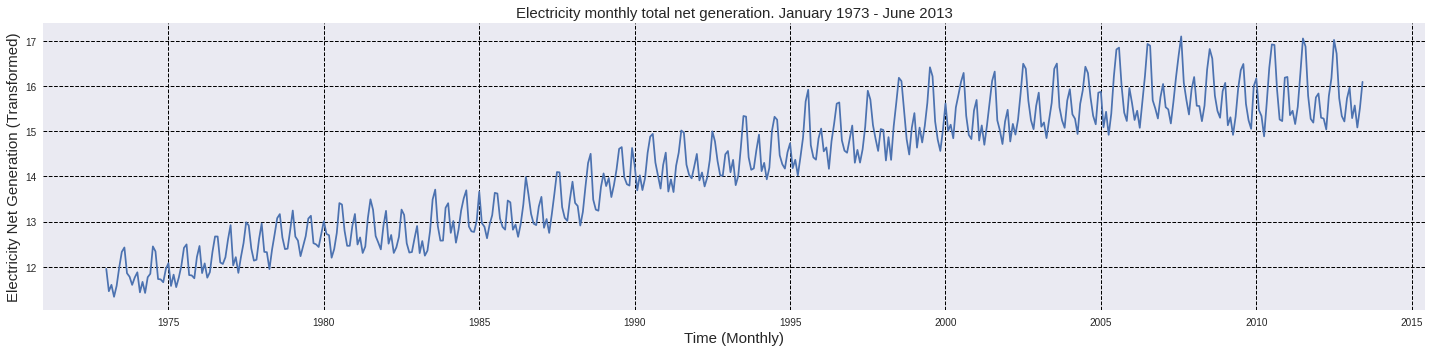

In [5]:
ts_usmelec_transformed = box_cox_transformation(ts_usmelec, lambd = 0.3)

# plotting the transformed series
plot_time_series(ts_usmelec_transformed, xlabel = "Time (Monthly)", ylabel = "Electricity Net Generation (Transformed)", title = "Electricity monthly total net generation. January 1973 - June 2013")

**A value of lambda between 0.3 and 0.5 leads to a tranformation with almost same variance throughout**

**1.2 usgdp**

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa9784e80>)

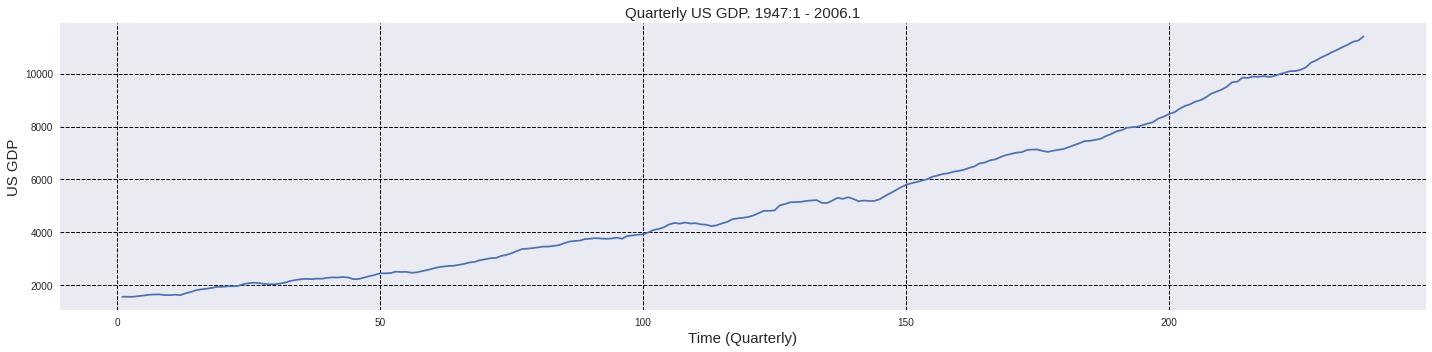

In [6]:
# let's explore the usgdp data

ts_usgdp = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/usgdp.csv", index_col="Unnamed: 0")

# plotting the original data

plot_time_series(ts_usgdp, xlabel = "Time (Quarterly)", ylabel = "US GDP", title = "Quarterly US GDP. 1947:1 - 2006.1")

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8ef3278>)

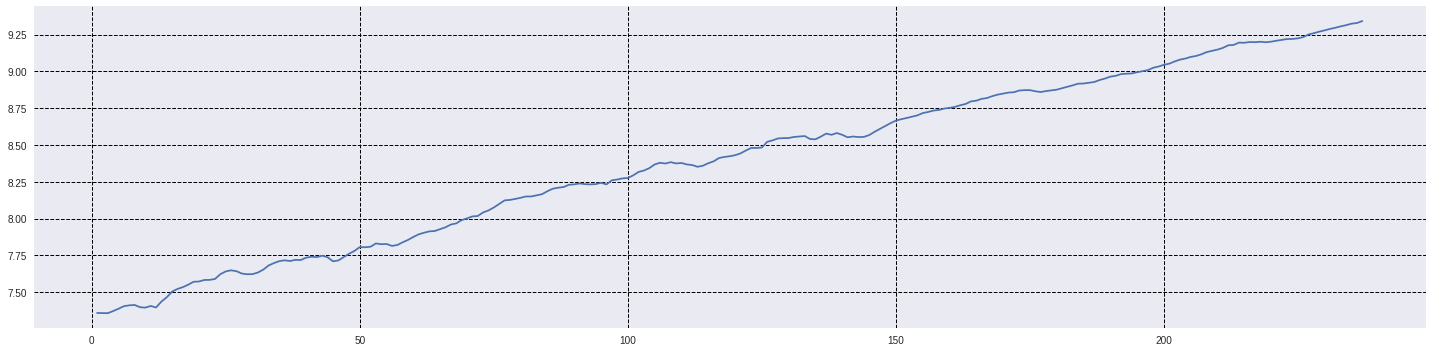

In [7]:
ts_usgdp_transformed = box_cox_transformation(ts_usgdp, lambd = 0)  # applying box cox tranformation on the original scale

# plotting the tranformed time series
plot_time_series(ts_usgdp_transformed)

**Taking a log tranformation or power tranformation does a decent job of stablizing the variance**

**1.3 mcopper**

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8e51940>)

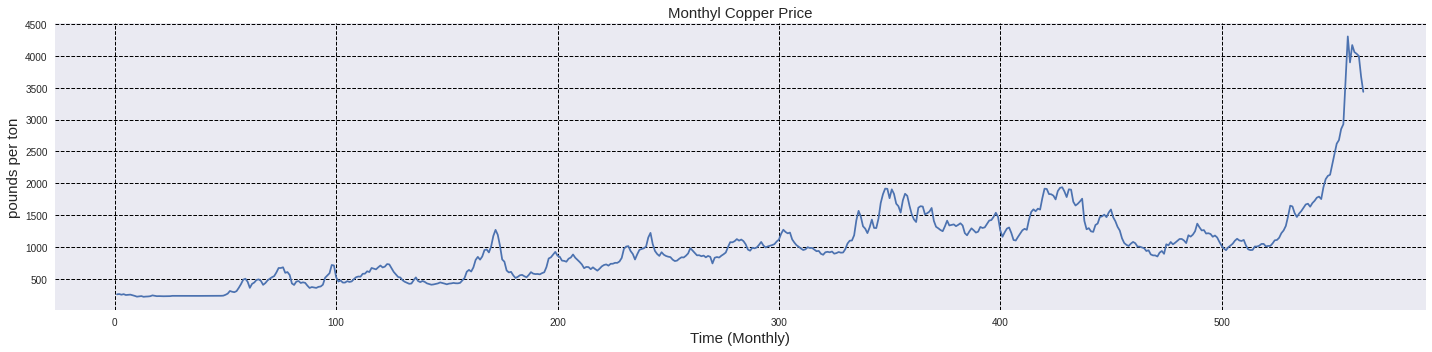

In [8]:
# Exploring the mcopper data

ts_mcopper = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/mcopper.csv", index_col="Unnamed: 0")

# plotting the original data
plot_time_series(ts_mcopper, xlabel = "Time (Monthly)", ylabel = "pounds per ton", title = "Monthyl Copper Price")

Data doesn't have contant variance throughout. Let's see the impact of box cox tranformation on the data.

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8e7a8d0>)

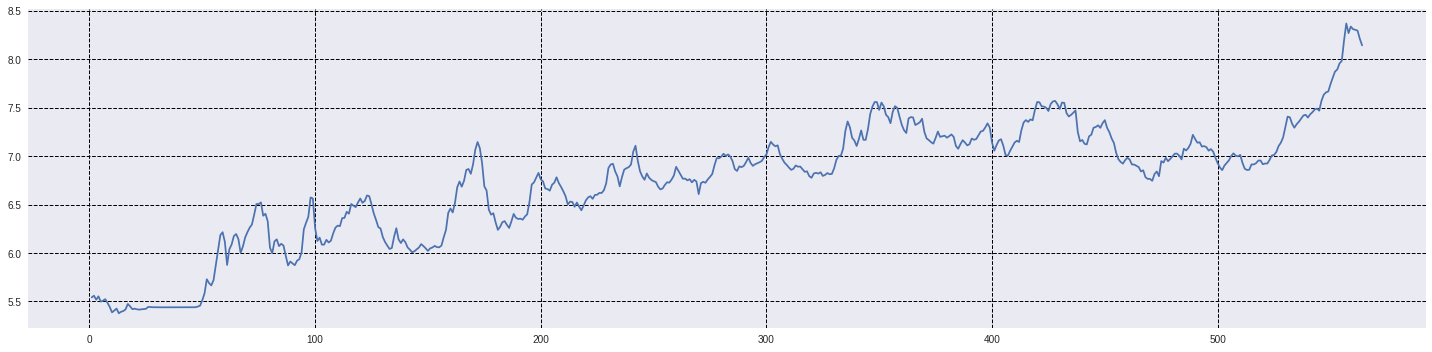

In [9]:
ts_mcopper_transformed = box_cox_transformation(ts_mcopper, lambd = 0)

# plotting the tranformed time series

plot_time_series(ts_mcopper_transformed)

**Log tranformation has done a great job in stablizing the variance throughout the data**

**1.4 enplanements**

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8da8860>)

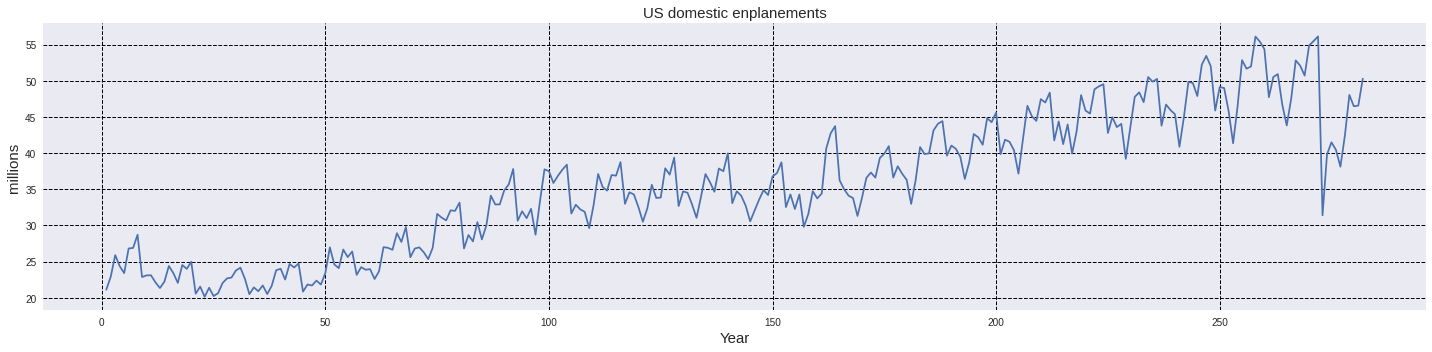

In [10]:
# Exploring the enplanements data

ts_enplanements = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/enplanements.csv", index_col = "Unnamed: 0")

# plotting the time series data
plot_time_series(ts_enplanements, xlabel="Year", title = "US domestic enplanements", ylabel="millions")

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8d6e3c8>)

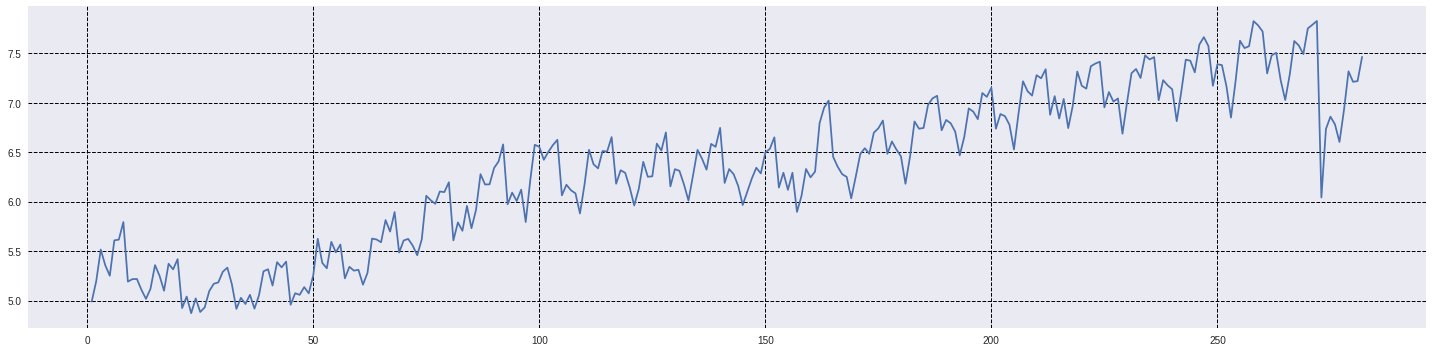

In [11]:
ts_enplanements_tranformed = box_cox_transformation(ts_enplanements, lambd = 0.3)

# plotting the tranformed data

plot_time_series(ts_enplanements_tranformed)

**Power tranformation with lambda of value between 0.3 and 0.5 would be a desent choice. Though, data seems almost unchanged after the tranformation.**

# Question: 2

Why is a Box-Cox transformation unhelpful for the cangas data?

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8cf14a8>)

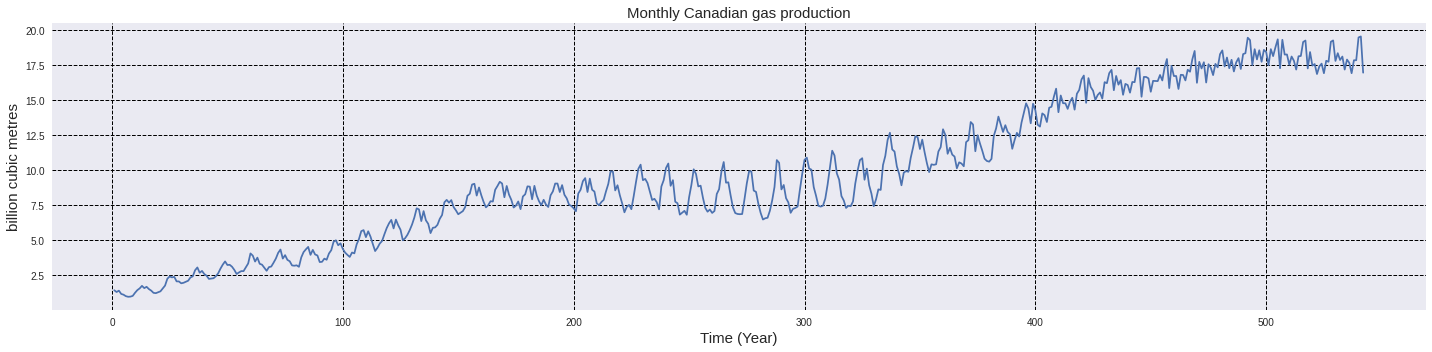

In [12]:
# importing the cangas data
ts_cangas = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/cangas.csv", index_col="Unnamed: 0")

# plotting the data
plot_time_series(ts_cangas, xlabel = "Time (Year)", ylabel = "billion cubic metres", title = "Monthly Canadian gas production")

Data doesn't have a constant variance throughout

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8d01668>)

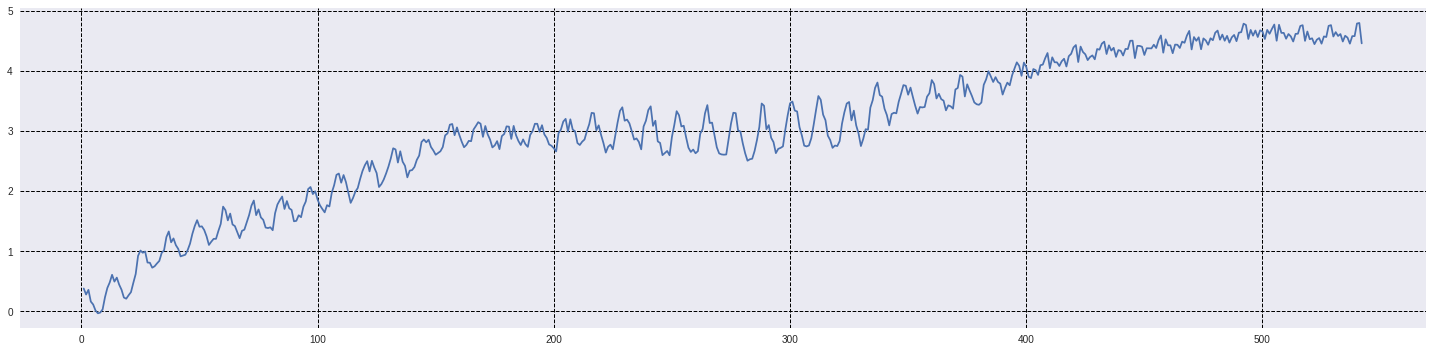

In [13]:
ts_cangas_tranformed = box_cox_transformation(ts_cangas, lambd = 0.3)  # box cox tranformation of the data

# plotting the transformed data

plot_time_series(ts_cangas_tranformed)

**Conclusion: Neither log or power tranformation is useful for cangas data as transformation is not making the variance constant throughout. Therefore, box cox tranformation is useless for this data.**

# Question: 3 

What Box-Cox transformation would you select for your retail data (from Exercise 3 in Section 2.10)?

In [14]:
ts_retail = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/retail.xlsx", skiprows=[1], index_col = "Unnamed: 0")

categories = ts_retail.columns  # names of all the columns

random_category = np.random.choice(categories)  # picking a random time series from all the categories

ts_retail = ts_retail[[random_category]]

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa77d62b0>)

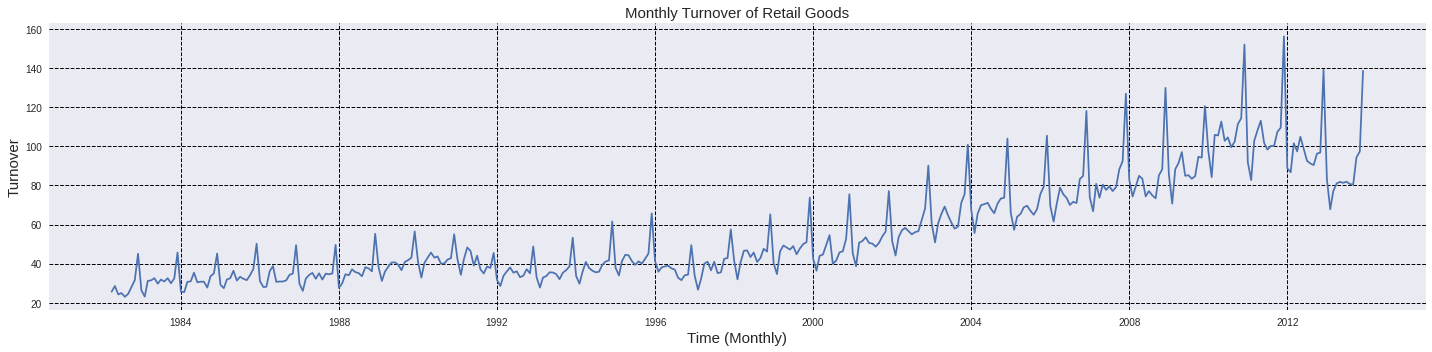

In [15]:
# plotting the time series data
plot_time_series(ts_retail, xlabel = "Time (Monthly)", ylabel = "Turnover", title = "Monthly Turnover of Retail Goods")

Data doesn't have a contant variance througout. A simpler data always leads to better prediction. Let's see if box cox tranformation can make the variance contant throughout.

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8c57438>)

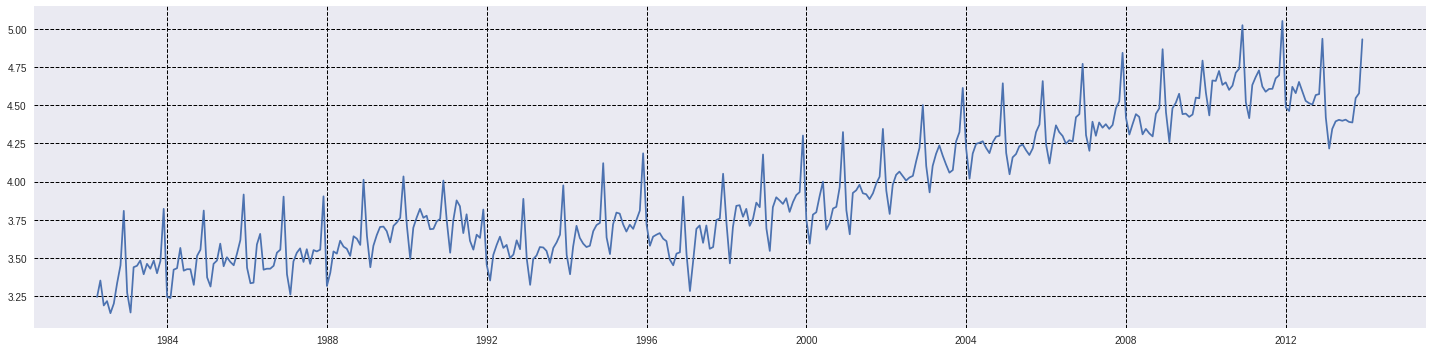

In [16]:
ts_retail_tranformed = box_cox_transformation(ts_retail, lambd = 0.0)

# plotting the tranformed data

plot_time_series(ts_retail_tranformed)

**Conclusion: Taking the log tranformation of the original data makes the variance contant throughout.**

# Question: 4

For each of the following series, make a graph of the data. If transforming seems appropriate, do so and describe the effect. dole, usdeaths, bricksq.

**4.1 dole**

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa874b5f8>)

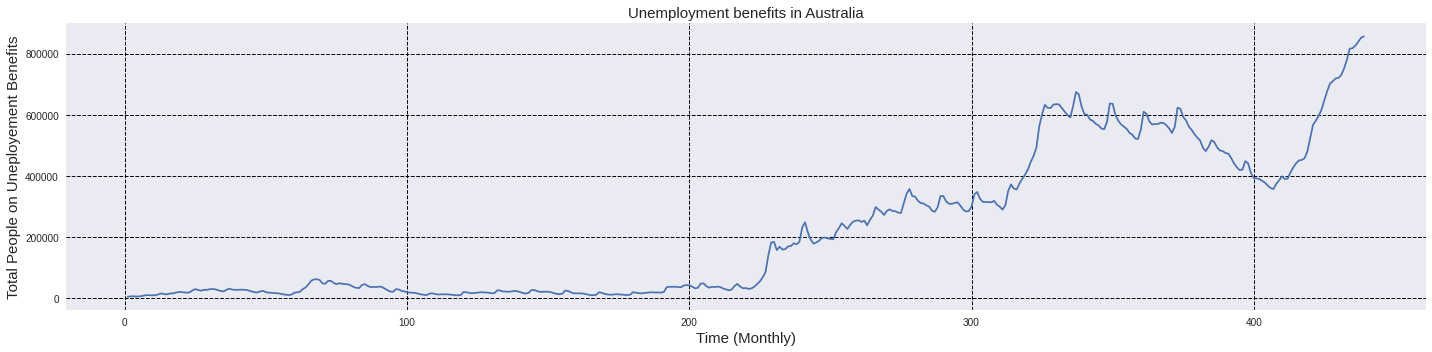

In [17]:
ts_dole = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/dole.csv", index_col="Unnamed: 0")

# plotting the time series data
plot_time_series(ts_dole, xlabel = "Time (Monthly)", ylabel = "Total People on Uneployement Benefits", title = "Unemployment benefits in Australia")

dole data doesn't have a contant variance throughout

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8823208>)

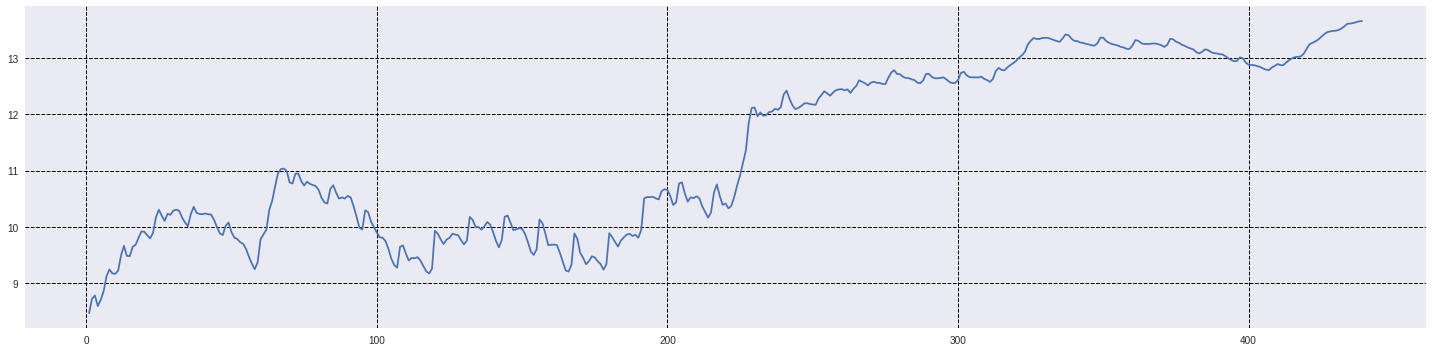

In [18]:
ts_dole_tranformed = box_cox_transformation(ts_dole, lambd = 0.0)

# plotting the tranformed data

plot_time_series(ts_dole_tranformed)

**Conclusion: Taking a log tranformation of the data makes the variance contant throughout.**

**4.2 usdeaths**

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa8773588>)

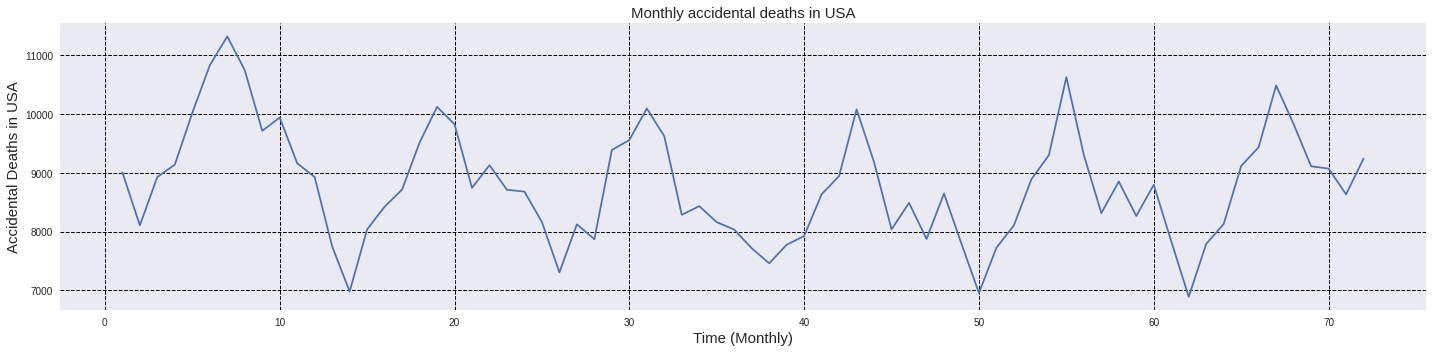

In [19]:
ts_usdeaths = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/usdeaths.csv", index_col = "Unnamed: 0")

# plotting the time series

plot_time_series(ts_usdeaths, xlabel = "Time (Monthly)", ylabel = "Accidental Deaths in USA", title = "Monthly accidental deaths in USA")

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa88677f0>)

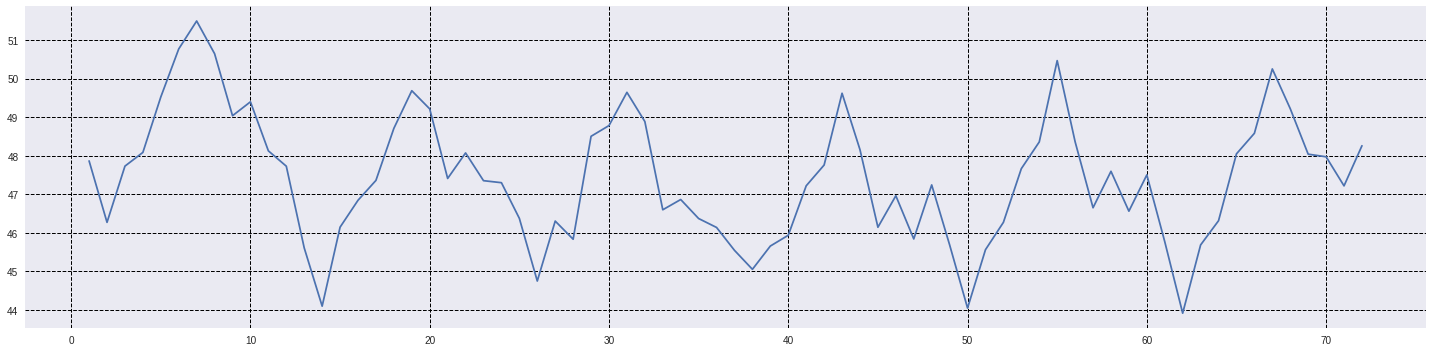

In [20]:
ts_usdeaths_transformed = box_cox_transformation(ts_usdeaths, lambd = 0.3)

# plotting the transformed time series

plot_time_series(ts_usdeaths_transformed)

**Conclusion: Data already has a contant mean throughout. Using tranformation on this data will not have any visible impact**

**4.3 bricksq**

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa79c4630>)

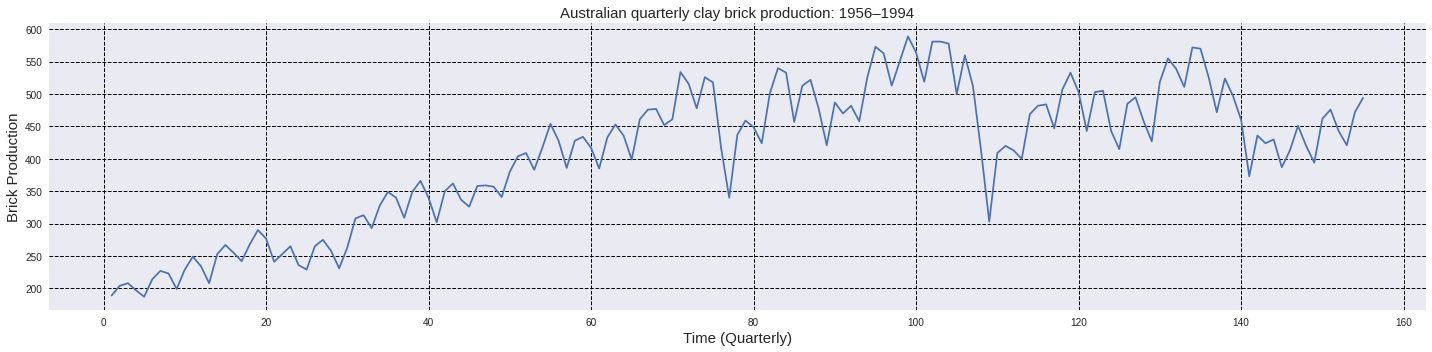

In [21]:
ts_bricksq = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/bricksq.csv", index_col = "Unnamed: 0")

# plotting the data

plot_time_series(ts_bricksq, xlabel = "Time (Quarterly)", ylabel = "Brick Production", title = "Australian quarterly clay brick production: 1956–1994")

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa7cc6470>)

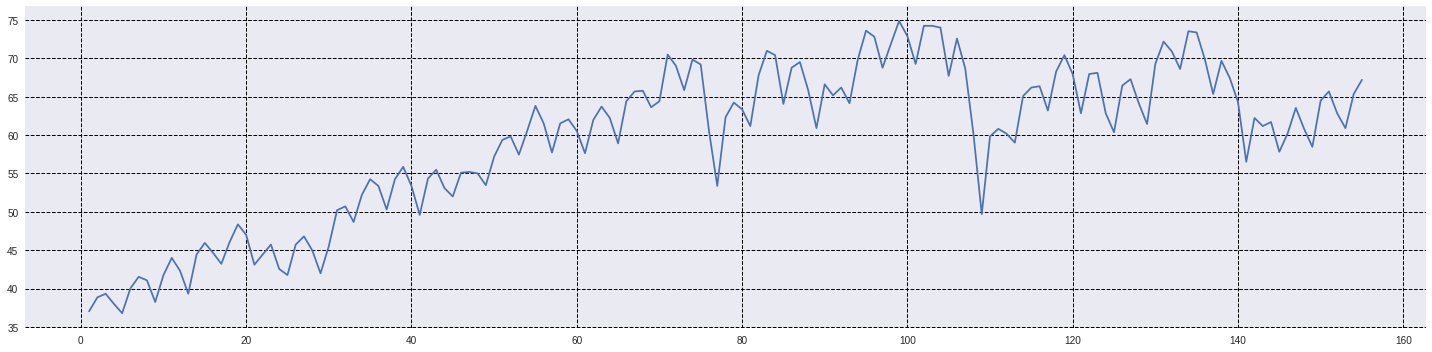

In [22]:
ts_bricksq_transformed = box_cox_transformation(ts_bricksq, lambd = 0.6)

# plotting the tranformed data

plot_time_series(ts_bricksq_transformed)

**Conclusion: Neither log or power tranformation has any effect on variance of the data**

**Final Conclusion:**



1.   If a transformation can make the variance contant throughout, use it or else don't use tranformations
2.   If using tranformation, make predictions on tranformed data and then scale it back to the original scale
3. Transformations are not always likely to use in most of the data



# Question: 5

Calculate the residuals from a seasonal naïve forecast applied to the quarterly Australian beer production data from 1992. 

Test if the residuals are white noise and normally distributed.

What do you conclude?

In [23]:
# importing the data
ts_ausbeer = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/ausbeer.csv", index_col='time')
ts_ausbeer.drop("Unnamed: 0", axis = 1, inplace = True)
ts_ausbeer = ts_ausbeer[1992.00:]  # slicing the data from year 1992 onwards
ts_ausbeer.head()

,value
time,
1992.00,443
1992.25,410
1992.50,420
1992.75,532
1993.00,433


(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa7d51c88>)

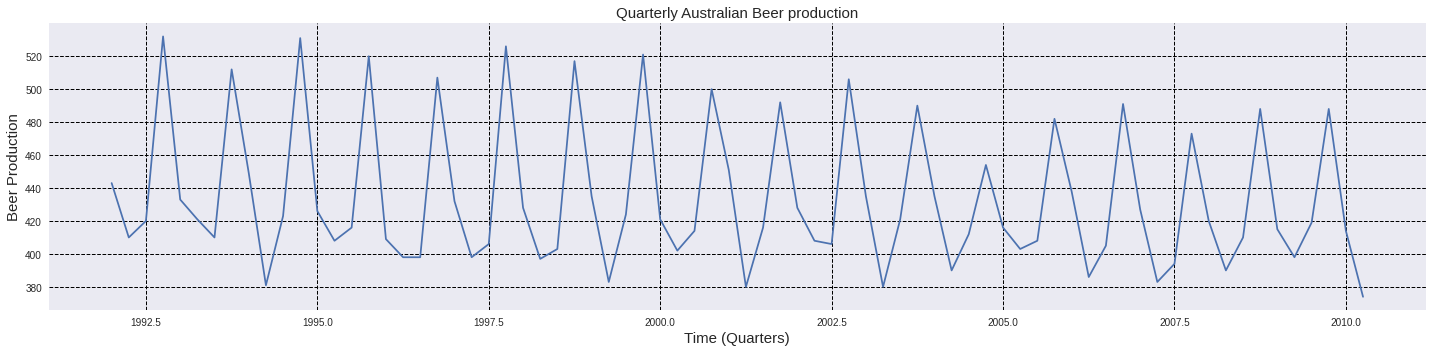

In [24]:
# plotting the time series data
plot_time_series(ts_ausbeer, "Time (Quarters)", "Beer Production", "Quarterly Australian Beer production")

In [25]:
# applying the seasonal naive forecast on the data
ts_ausbeer_forecasts = s_naive_forecast(ts_ausbeer, 4, horizon_start=1992.00, horizon_end=2010.25)
ts_ausbeer_forecasts.rename(columns={0: "value"}, inplace = True)
ts_ausbeer_forecasts.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,value
time,
1992.00,0.0
1992.25,0.0
1992.50,0.0
1992.75,0.0
1993.00,443.0


In [26]:
# Computing the residuals for the forecasts
residuals = ts_ausbeer - ts_ausbeer_forecasts
residuals = residuals.loc[1993.00:, :]  # removing the first four residuals as we do not have the forecasts for these using s-naive forecast

**5.1 Plotting the time-series of the residuals**

Mean of the residuals:  value   -1.571429
dtype: float64


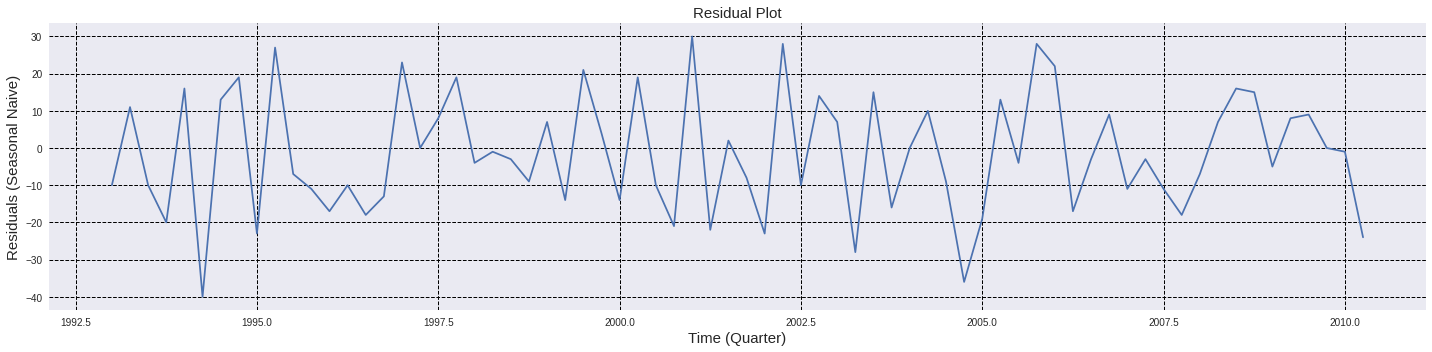

In [27]:
plot_time_series(residuals, xlabel = "Time (Quarter)", ylabel = "Residuals (Seasonal Naive)", title = "Residual Plot")
print("Mean of the residuals: ", np.mean(residuals))

**5.2 Checking the Auto-Correlation between the residuals**

Figure(576x396)
P-value obtained from the ljung-box test is  [8.33561066e-05]


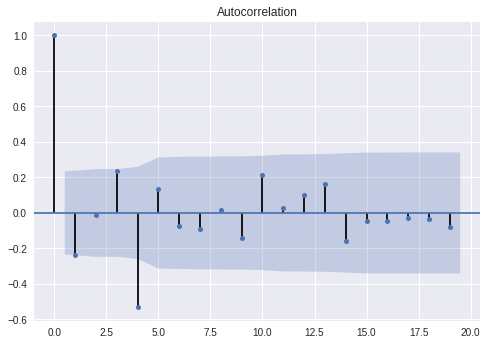

In [28]:
# plotting the auto-correlation function plot for the residuals
print(plot_acf(residuals.loc[1993.00:, :]))

# performing the ljung-box test for checking the auto-correaltion between residuals
p_value = sm.stats.diagnostic.acorr_ljungbox(residuals, lags=[8])[1]

print("P-value obtained from the ljung-box test is ", p_value)

**5.3 Checking the distribution of residuals**

p-value for shapiro wilik test is  0.38650640845298767


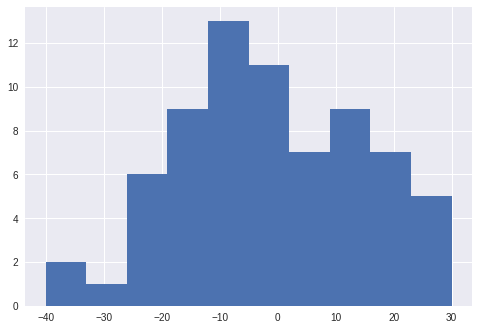

In [29]:
# plotting the histogram of residuals
plt.hist(residuals.values)

# performing shapiro-wilik test for normality
print("p-value for shapiro wilik test is ", stats.shapiro(residuals.values)[1])

**Conclusion:**

1. **No Auto-Correlation**: Both ACF plot and ljun-box test suggest that there is an auto-correlation between the residuals.

Ljung-Box Test: Assumes null hypothesis as no aauto-correlation between the residuals. p-value is less than 0.005. Hence, rejecting the null hypothesis in facour of alternative hypothesis that there is an auto-correlation between the residuals.

2. **Zero Mean**: From time series it looks like the mean is close to zero. Actual value of mean is -1.57. Very close to zero but not exactly zero

**Above points suggests that the residuals are not white noise and hence seasonal naive fails to capture all the available information present in the data. Therefore, a better forecasting model is required.**

Additional Properties of residuals:

1. **Contant Variance**: Variance looks constant throughout with some outliers.

2. **Normal Distribution**: Both histogram and shapiro-wilik test suggests that residuals are normally distributed.

Shapiro Wilik Test: Assumes null hypothesis as data is normally distributed and p-value > 0.005 so we go with the null hypothesis that residuals are normally distributed. 

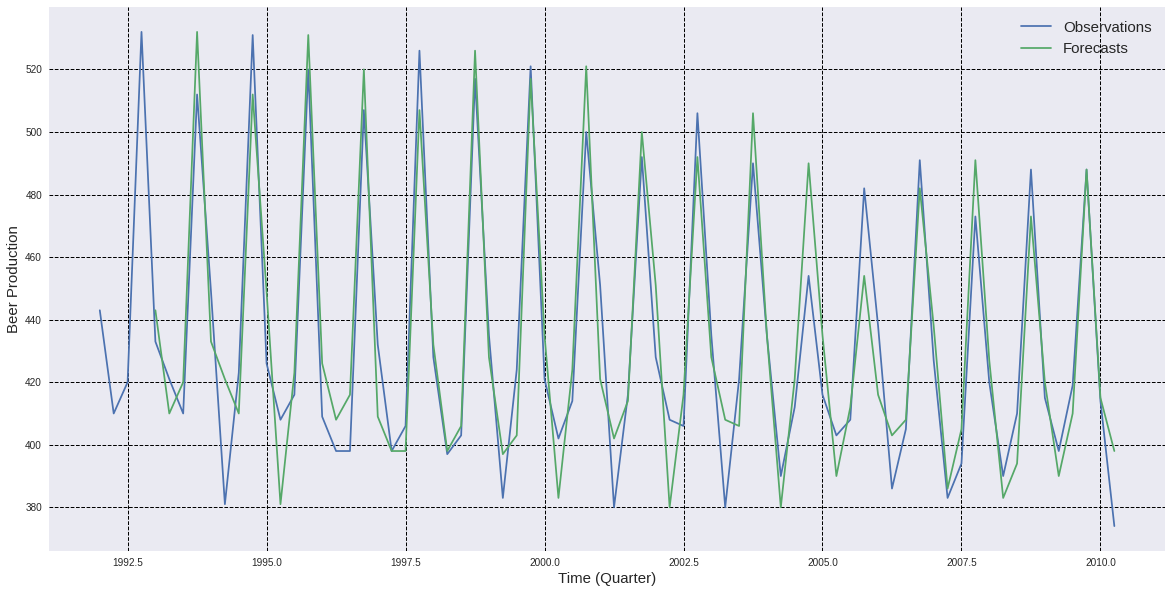

In [30]:
# plotting the original data and the forecasts on the same plot
plt.figure(figsize = (20, 10))
plt.plot(ts_ausbeer, label = 'Observations')
plt.plot(ts_ausbeer_forecasts.loc[1993.00:, :], label = 'Forecasts')
plt.grid(linestyle = '--', color = 'black')
plt.xlabel("Time (Quarter)", fontsize = 15)
plt.ylabel("Beer Production", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

# Question: 6

Repeat the exercise for the WWWusage and bricksq data. Use whichever of naive() or snaive() is more appropriate in each case.

**6.1 WWWusage**

In [31]:
ts_wwwusage = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/WWWusage.csv', index_col = 'time')
ts_wwwusage.drop("Unnamed: 0", axis = 1, inplace = True)
ts_wwwusage.describe()

,value
count,100.000000
mean,137.080000
std,39.999414
min,83.000000
25%,99.000000
50%,138.500000
75%,167.500000
max,228.000000


(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa7c45048>)

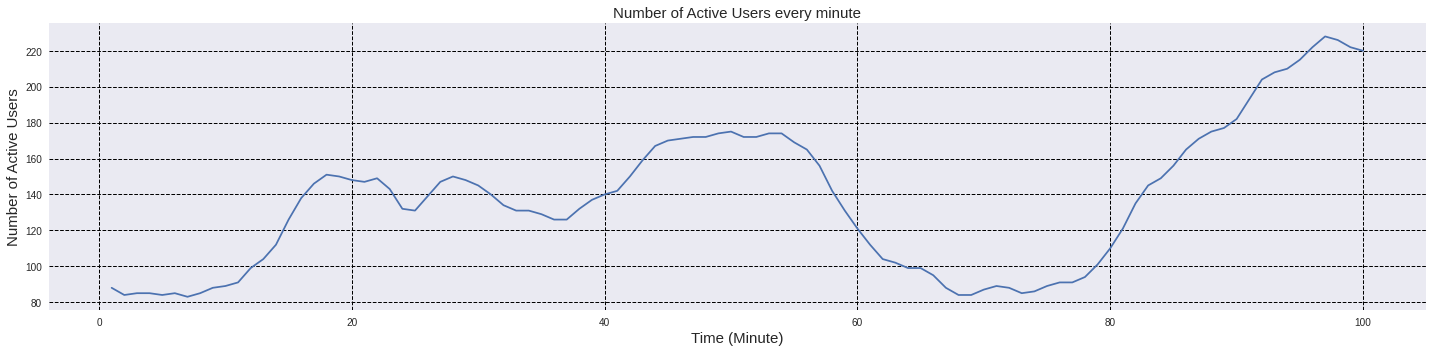

In [32]:
# plotting the time series data
plot_time_series(ts_wwwusage, "Time (Minute)", "Number of Active Users", "Number of Active Users every minute")

Looks like a random walk and hence naive method is a better choice.

In [33]:
ts_wwwusage_forecasts = s_naive_forecast(ts_wwwusage, 2, horizon_start = 1, horizon_end = 100)  # computing the forecast
ts_wwwusage_forecasts.rename(columns = {0: "value"}, inplace = True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [34]:
residuals = ts_wwwusage - ts_wwwusage_forecasts  # computing the forecast for the naive forecast
residuals = residuals.loc[2:, :]  # removing the first observation from the residuals as we don't have the forecast for the first observation

**6.1.1 Plotting Time Series for Residuals**

Mean of the residuals is  value    1.333333
dtype: float64


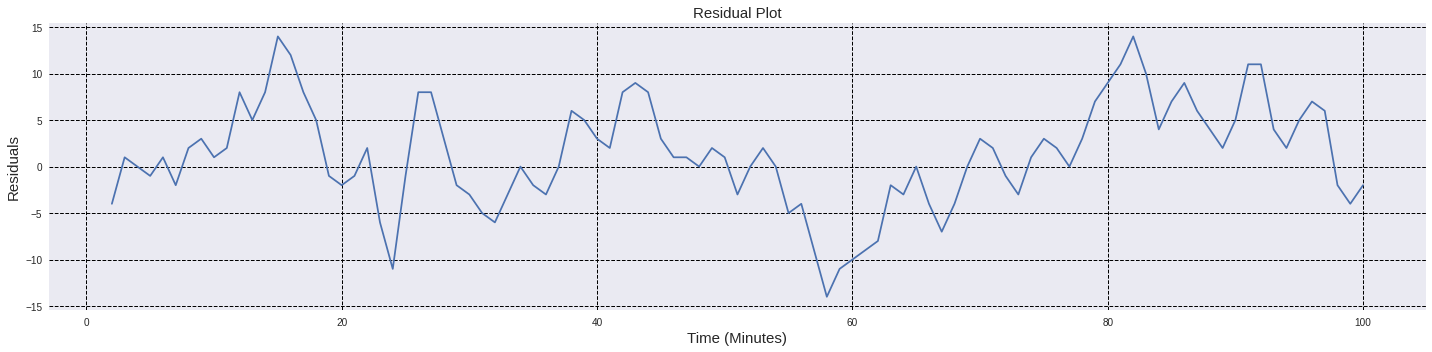

In [35]:
plot_time_series(residuals, xlabel = 'Time (Minutes)', ylabel = "Residuals", title = "Residual Plot")
print("Mean of the residuals is ", np.mean(residuals))

**6.1.2 Check for Auto-Correlatin Amongst Residuals**

P-value for the ljung box test is  [3.01271971e-26]


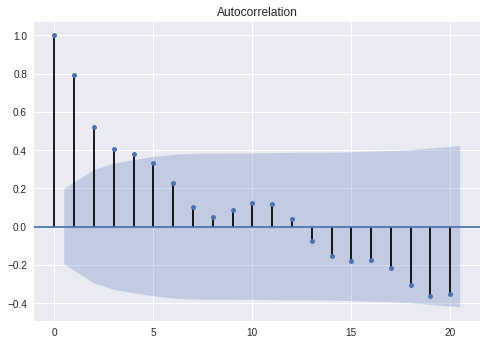

In [36]:
# plotting the auto correlation function for residuals
plot_acf(residuals)

# ljung-box test for auto-correlation function
p_value = sm.stats.diagnostic.acorr_ljungbox(residuals, lags = [10])[1]
print("P-value for the ljung box test is ", p_value)

**6.1.3 Normality of Residuals Test**

p-value for shapiro test is 0.5996686220169067


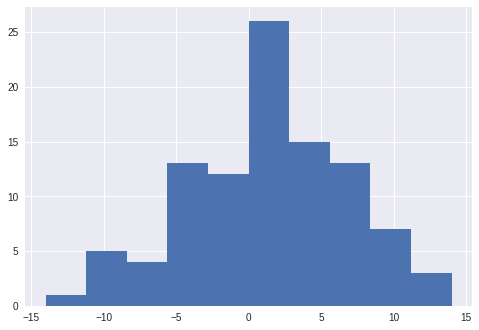

In [37]:
# plotting the histogram of the residuals
plt.hist(residuals.values)

# performing shapiro-wilik test for normality
p_value = stats.shapiro(residuals)[1]
print("p-value for shapiro test is", p_value)

**Conclusion:**

1. **No Auto-Correlation**: Both ACF plot and ljung box test suggest that there is an auto-correaltion amongst the residuals. 

Ljung-Box Test: Assumes a null hypothesis that there is no auto-correlation amongst residuals, But, p-value < 0.005 suggest that we reject the null hypothesis in favour of alternative hypothesis that there is an auto-correaltion.

2. **Zero Mean**: Mean is 1.33 close to zero but not exactly zero. 

Conclusion: Above two points signifies that the residuals are not white noise and there is information left in the data which is not captured by the naive method and hence naive is not the optimal forecast method to be used for this data.

Additional Properties:

1. Contant variance: Looks like variance is contant throughout.

2. Normal Distribution of Residuals: Both histogram and shapiro-wilik test confirms the normal distribution of residuals and hence prediction intervals would be more accurate.

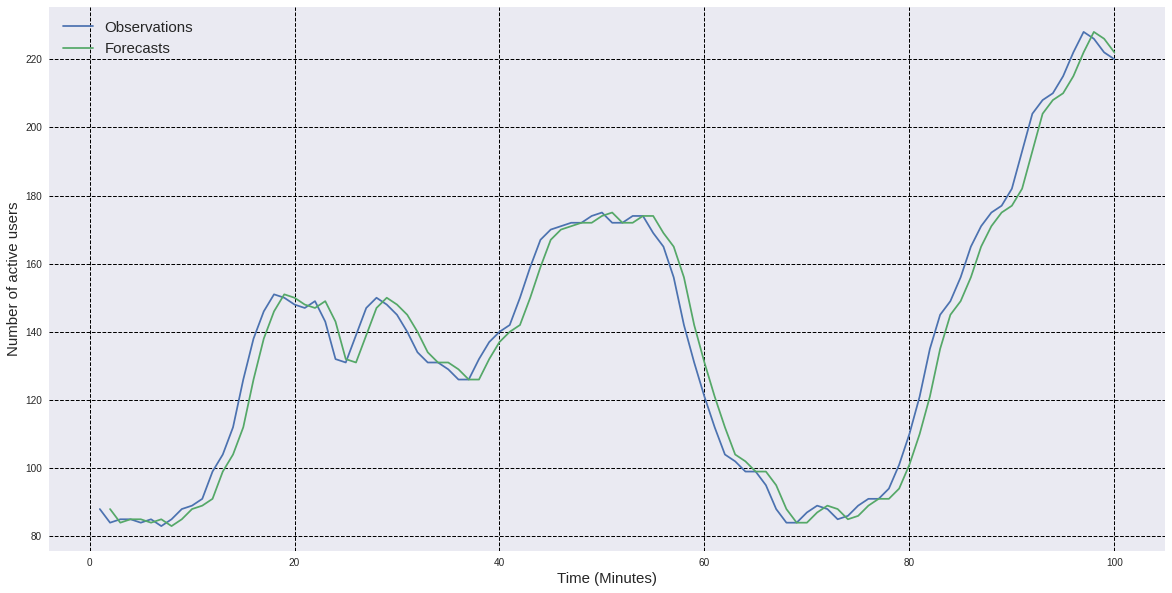

In [38]:
# plotting the original data and the forecasts on the same plot
plt.figure(figsize = (20, 10))
plt.plot(ts_wwwusage, label = 'Observations')
plt.plot(ts_wwwusage_forecasts.loc[2:, :], label = 'Forecasts')
plt.grid(linestyle = '--', color = 'black')
plt.xlabel("Time (Minutes)", fontsize = 15)
plt.ylabel("Number of active users", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

**6.2 bricksq**

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa795ea90>)

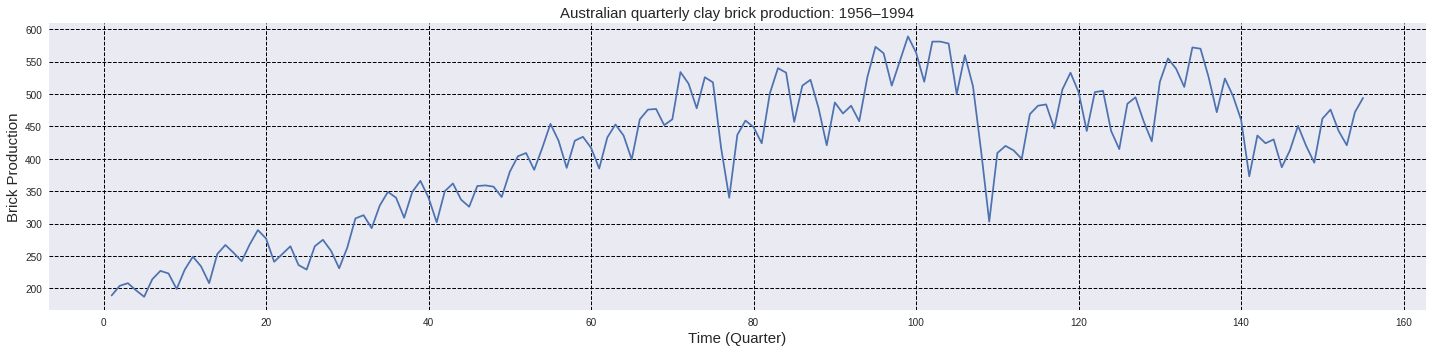

In [39]:
ts_bricksq = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/bricksq.csv", index_col = "Unnamed: 0")
ts_bricksq.rename(columns = {'x': 'value'}, inplace = True)

# plotting the time series data
plot_time_series(ts_bricksq, xlabel = "Time (Quarter)", ylabel = "Brick Production", title = "Australian quarterly clay brick production: 1956–1994")

Seasonal pattern is present in the data. Using seasonal naive.

In [117]:
ts_bricksq_forecasts = s_naive_forecast(ts_bricksq, 5, horizon_start=1, horizon_end = 155)  # computing the forecasts
ts_bricksq_forecasts.rename(columns = {0: "value"}, inplace = True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [41]:
residuals = ts_bricksq - ts_bricksq_forecasts  # computing the residuals
residuals = residuals.loc[5:, :]  # removing the first four rows as we do not have the forecasts for first season

**6.2.1 TIme Series Plot for the Residuals**


Mean of the residuals is value    6.834437
dtype: float64


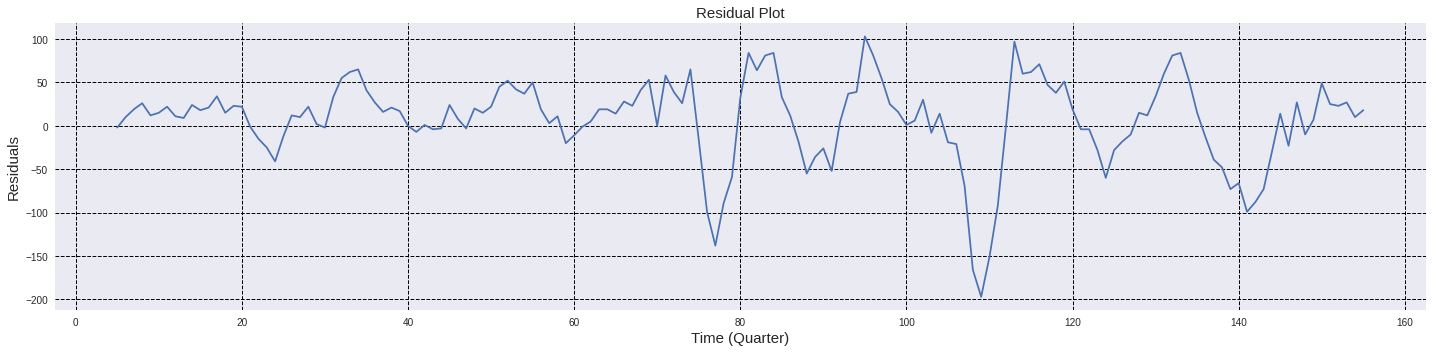

In [42]:
plot_time_series(residuals, xlabel = "Time (Quarter)", ylabel = 'Residuals', title = "Residual Plot")

print("Mean of the residuals is", np.mean(residuals))

**6.2.2 Check for Auto-Correlation between Residuals**

p-value of ljung-box test is [6.24213924e-46]


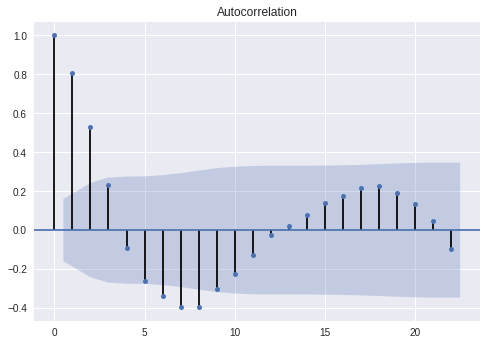

In [43]:
plot_acf(residuals)

# Ljung-box test

p_value = sm.stats.diagnostic.acorr_ljungbox(residuals, lags = [8])[1]
print("p-value of ljung-box test is", p_value)

**6.2.3 Check for normal distribution**

P-value of shapiro wilik test is 4.768948258515593e-08


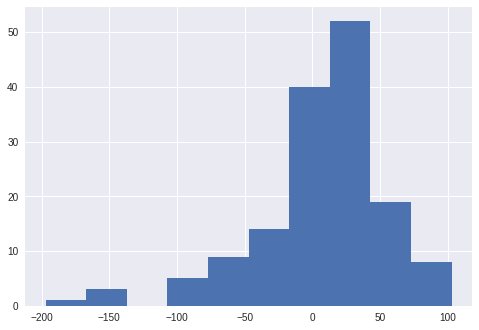

In [44]:
# plotting the histogram of the residuals
plt.hist(residuals.values)

# shapiro-wilik test for normality
p_value = stats.shapiro(residuals)[1]
print("P-value of shapiro wilik test is", p_value)

**Conlusion**

1. **No Auto-Correlation**: Both ACF plot and ljung boxx suggest that there is an auto-correlation between the residuals.

2. **Zero Mean**: Mean of the residuals is 6.3 which is not at all close to zero.

Addition Properties:

1. **Constant variance**: Looks like residuals has many outliers and thus variance is not constant throughtout. 

2. **Normal Distribution**: Histogram and shapiro wilik test suggest that residuals are not normally distributed.

Final: Residuals are not white noise and hence seasonal naive method does not capture all the information available in the data.

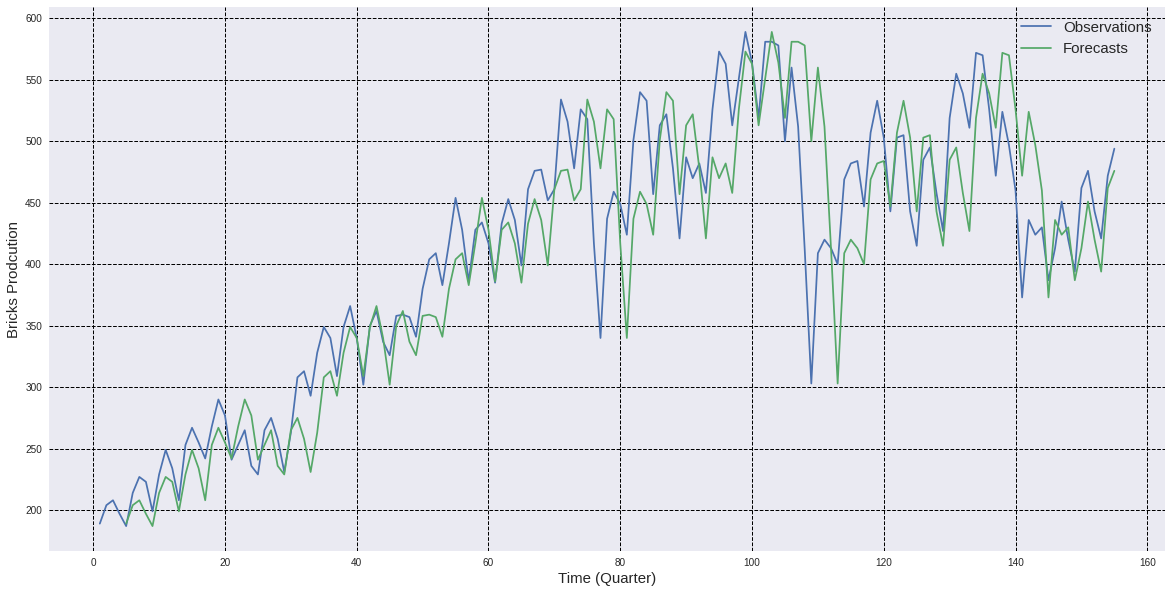

In [45]:
# plotting the original data and the forecasts on the same plot
plt.figure(figsize = (20, 10))
plt.plot(ts_bricksq, label = 'Observations')
plt.plot(ts_bricksq_forecasts.loc[5:, :], label = 'Forecasts')
plt.grid(linestyle = '--', color = 'black')
plt.xlabel("Time (Quarter)", fontsize = 15)
plt.ylabel("Bricks Prodcution", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

# Question: 8

For your retail time series (from Exercise 3 in Section 2.10):

* Split the data into two parts using

myts.train <- window(myts, end=c(2010,12))
myts.test <- window(myts, start=2011)

* Check that your data have been split appropriately by producing the following plot.

* Calculate forecasts using snaive applied to myts.train.

* Compare the accuracy of your forecasts against the actual values stored in myts.test.

* Check the residuals.

* Do the residuals appear to be uncorrelated and normally distributed?

* How sensitive are the accuracy measures to the training/test split?

In [46]:
ts_retail = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/retail.xlsx", skiprows=[1], index_col = 'Unnamed: 0')

random_category = np.random.choice(ts_retail.columns)  # selecting a random category from retail data frame

ts_retail = ts_retail[[random_category]]

**8.1 Splitting the data into training and testing set**

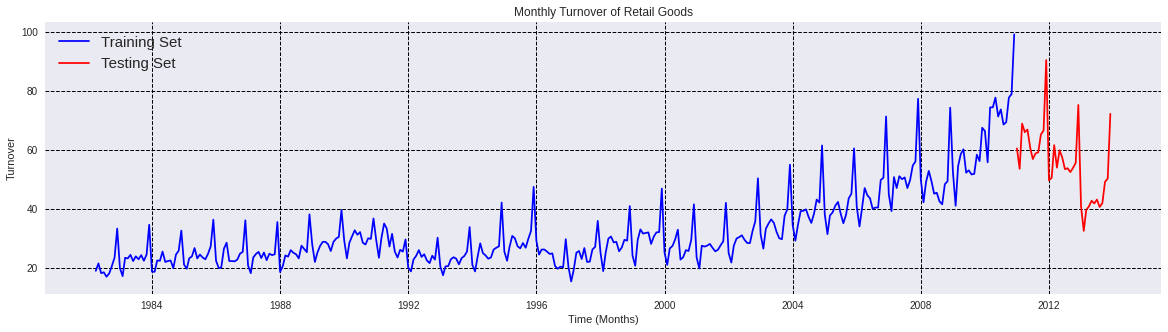

In [47]:
ts_retail.rename(columns = {random_category: 'value'}, inplace = True)

ts_training = ts_retail.loc[:'2010-12-01', :]  # training set
ts_testing = ts_retail.loc['2011-01-01':, :]  # testing set

# plotting the training and testing set
fig, ax = plt.subplots(1, 1)

fig.set_figheight(5)
fig.set_figwidth(20)

ax.plot(ts_training, color = 'blue', label = 'Training Set')
ax.plot(ts_testing, color = 'red', label = 'Testing Set')
ax.grid(color = 'black', linestyle = '--')

ax.set_xlabel("Time (Months)")
ax.set_ylabel("Turnover")
ax.set_title("Monthly Turnover of Retail Goods")

ax.legend(fontsize = 15)

**8.2 Applying Seasonal Naive forecast on the training set**

In [48]:
seasonal_period = 12  # monthly data

horizon_start = ts_testing.index[0]
horizon_end = ts_testing.index[-1]

ts_testing_forecasts = s_naive_forecast(ts_training, seasonal_period, horizon_start, horizon_end)
ts_testing_forecasts.rename(columns = {0: 'value'}, inplace = True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


**8.3 Computing the Accuracy of the sesonal naive method on the testing set**

In [49]:
MAE = mean_absoulte_error(ts_testing, ts_testing_forecasts)
print("Mean Abosulte Error:", MAE)

RMSE = root_mean_squared_error(ts_testing, ts_testing_forecasts)
print("Root Mean Squared Error:", RMSE)

MAPE = mean_absolute_percentage_error(ts_testing, ts_testing_forecasts)
print("Mean Absolute Percentage Error:", MAPE)

Mean Abosulte Error: value    18.730556
dtype: float64
Root Mean Squared Error: value    20.838366
dtype: float64
Mean Absolute Percentage Error: value    37.813955
dtype: float64


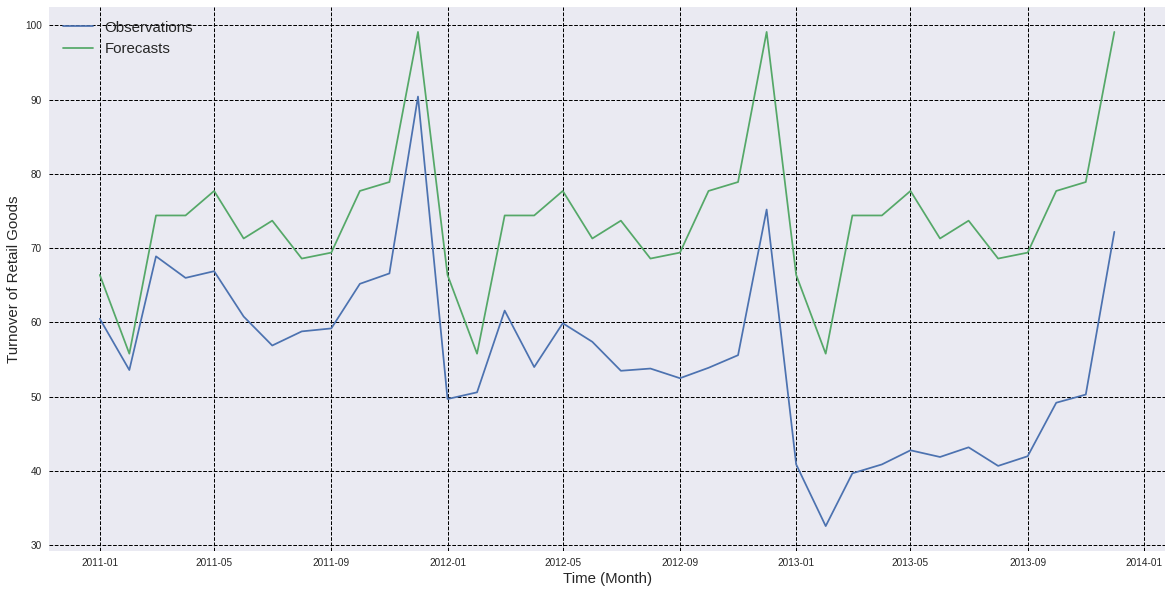

In [50]:
# plotting the actual observations and the forecasts for the testing set
plt.figure(figsize = (20, 10))
plt.plot(ts_testing, label = 'Observations')
plt.plot(ts_testing_forecasts, label = 'Forecasts')
plt.grid(linestyle = '--', color = 'black')
plt.xlabel("Time (Month)", fontsize = 15)
plt.ylabel("Turnover of Retail Goods", fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

**8.4 Checking the properties of residuals**

In [51]:
horizon_start = ts_training.index[seasonal_period]
horizon_end = ts_training.index[-1]

ts_training_forecasts = s_naive_forecast(ts_training, 12, horizon_start, horizon_end)  # computing forecasts for training set
ts_training_forecasts.rename(columns = {0: "value"}, inplace = True)

ts_training_residuals = ts_training - ts_training_forecasts  # computing the residuals
ts_training_residuals.dropna(inplace=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


**8.4.1 Plotting the Time Series of the Residuals**

Mean of the residuals: value    1.90991
dtype: float64


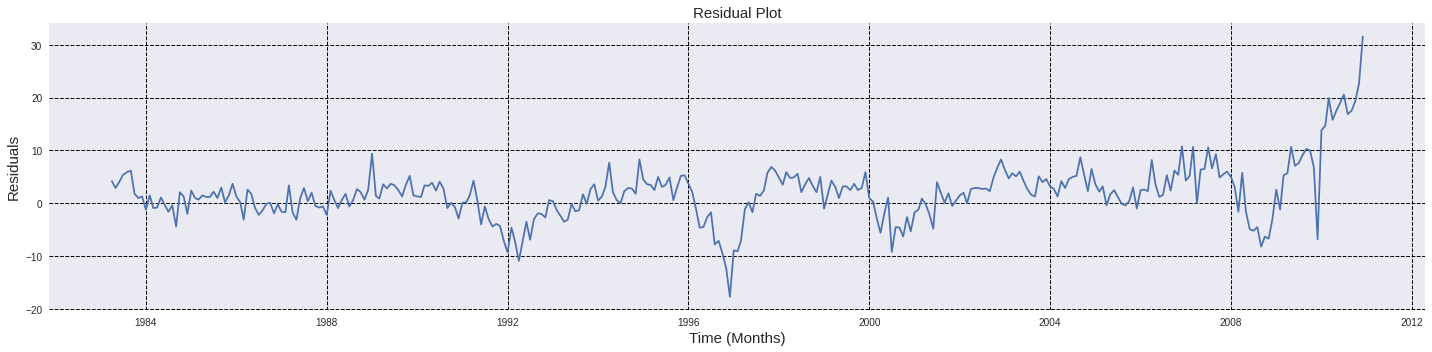

In [52]:
plot_time_series(ts_training_residuals, xlabel = 'Time (Months)', ylabel = "Residuals", title = "Residual Plot")

print("Mean of the residuals:", np.mean(ts_training_residuals))

**8.4.2 Check for Auto-Correlation**

P-value of ljung-box test: [6.17305978e-183]


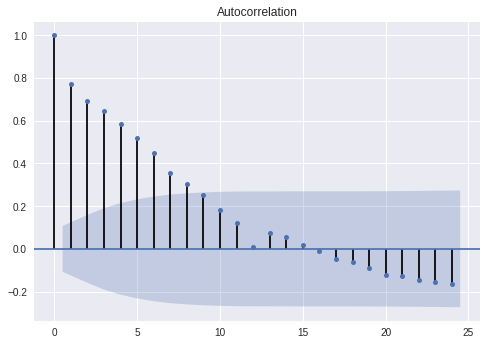

In [53]:
# plotting the auto-correaltion function for residuals

plot_acf(ts_training_residuals, lags = 24)

# performing Ljung-box test for auto-correlation
p_value = sm.stats.acorr_ljungbox(ts_training_residuals, lags = [24])[1]
print("P-value of ljung-box test:", p_value)

**8.4.3 Checking Normal Distribution of the Residuals**

p-value for shapiro test of normality: 7.289677216894275e-13


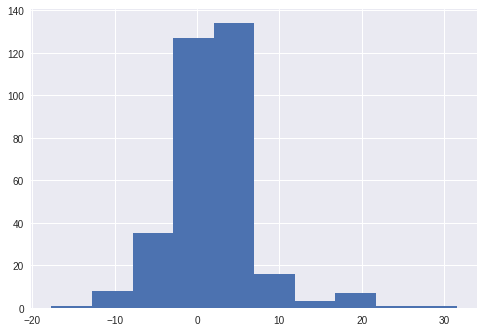

In [54]:
# plotting the histogram of the residuals
plt.hist(ts_training_residuals.values)

# shapiro-wilik test for normality
p_value = stats.shapiro(ts_training_residuals)[1]
print("p-value for shapiro test of normality:", p_value)

**Conclusion:**

1. **No Auto-Correaltion**: Both ACF plot and ljung-box test suggests that there is an auto-correaltion between the residuals.

2. **Zero Mean**: Residuals mean is not zero. It's 27

Residuals are not white noise. Seasonal naive is not capturing all the information available in the data and hence it is not the optimal choice of the forecasting method.

Additional Properties:

1. **Constant Variance**: variance is not contant thorughout based on time series plot

2. **Normal Distribution**: Both histogram and shapiro wilik test suggest that residuals are not normally distributed.

Residuals are not satifying the additional properties i.e. confidence interval won't be accurate.

# Question: 10

Use the Dow Jones index (data set dowjones) to do the following:

* Produce a time plot of the series.
* Produce forecasts using the drift method and plot them.
* Show that the forecasts are identical to extending the line drawn between the first and last observations.
* Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?

In [139]:
ts_dowjones = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/dowjones.csv", index_col="Unnamed: 0")
ts_dowjones.rename(columns = {'x': 'value'}, inplace = True)

**10.1 Time series plot of the data**

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8fa80f45c0>)

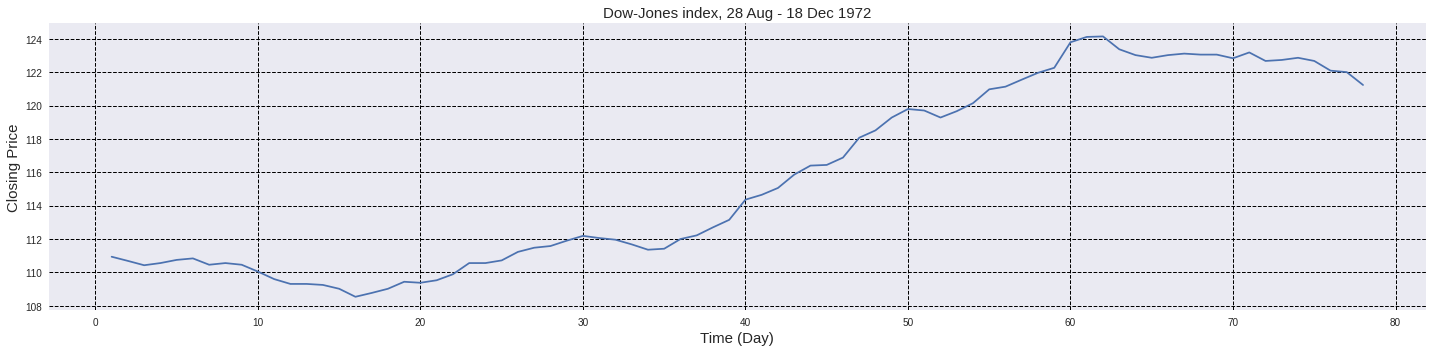

In [141]:
plot_time_series(ts_dowjones, xlabel = "Time (Day)", ylabel = "Closing Price", title = "Dow-Jones index, 28 Aug - 18 Dec 1972")

**10.2 Produce forecasts using the drift method and plot them**

In [195]:
y_t = ts_dowjones.iloc[-1, :].values  # last value in the training set

y_0 = ts_dowjones.iloc[0, :].values  # first value in the training set

m = (y_t - y_0) / len(ts_dowjones)

horizon_start = ts_dowjones.index[0]
horizon_end = ts_dowjones.index[-1]

h = np.linspace(horizon_start, horizon_end, (horizon_end-horizon_start) + 1, dtype = 'int')

ts_dowjones_forecasts = pd.DataFrame({'value': y_0 + m * h}, index = h)

**10.3 Show that the forecasts are identical to extending the line drawn between the first and last observations**

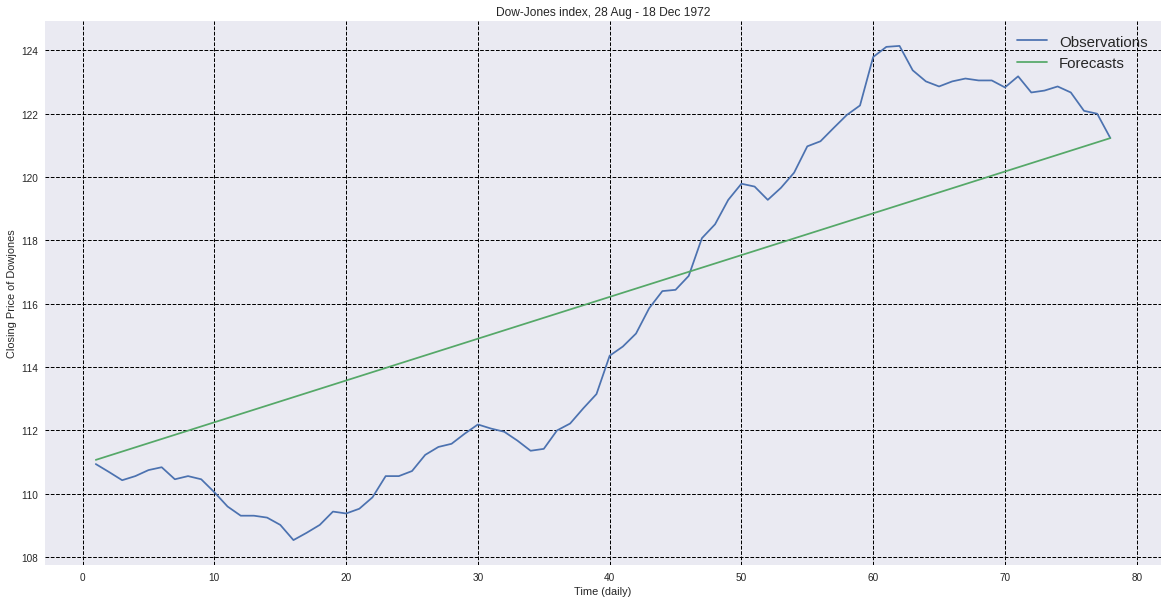

In [201]:
# plotting the dowjones time series and the forecasts on the same plot

plt.figure(figsize = (20, 10))
plt.plot(ts_dowjones, label = "Observations")
plt.plot(ts_dowjones_forecasts, label = "Forecasts")
plt.xlabel("Time (daily)")
plt.ylabel("Closing Price of Dowjones")
plt.title("Dow-Jones index, 28 Aug - 18 Dec 1972")
plt.grid(linestyle = '--', color = 'black')
plt.legend(fontsize = 15)
plt.show()

**10.4 Try using some of the other benchmark functions to forecast the same data set. Which do you think is best? Why?**

**10.4.1 Computing the forecasts using average and naive method**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


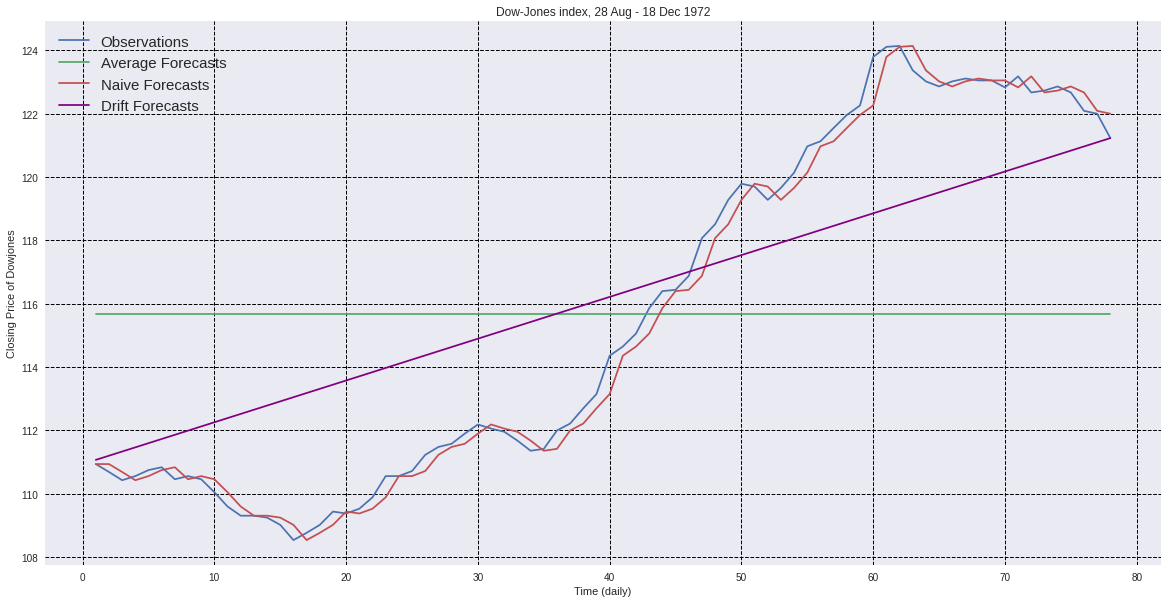

In [279]:
ts_dowjones_avg_forecasts = average_forecasts(ts_dowjones)

horizon_start = ts_dowjones.index[0]
horizon_end = ts_dowjones.index[-1]

ts_dowjones_naive_forecasts = s_naive_forecast(ts_dowjones, 2, horizon_start, horizon_end)
ts_dowjones_naive_forecasts.rename(columns={0: 'value'}, inplace = True)
ts_dowjones_naive_forecasts.iloc[0, :] = 110.94
# plotting the observations along with average, naive and drift forecasts
plt.figure(figsize = (20, 10))
plt.plot(ts_dowjones, label = "Observations")
plt.plot(ts_dowjones_avg_forecasts, label = "Average Forecasts")
plt.plot(ts_dowjones_naive_forecasts, label = "Naive Forecasts")
plt.plot(ts_dowjones_forecasts, label = "Drift Forecasts", color = 'purple')
plt.xlabel("Time (daily)")
plt.ylabel("Closing Price of Dowjones")
plt.title("Dow-Jones index, 28 Aug - 18 Dec 1972")
plt.grid(linestyle = '--', color = 'black')
plt.legend(fontsize = 15)
plt.show()

**Computing MAE, RMSE and MAPE for all the bechmaring methods**

In [286]:
average_MAE, average_RMSE, average_MAPE = accuracy(ts_dowjones, ts_dowjones_avg_forecasts)
naive_MAE, naive_RMSE, naive_MAPE = accuracy(ts_dowjones, ts_dowjones_naive_forecasts)
drift_MAE, drift_RMSE, drift_MAPE = accuracy(ts_dowjones, ts_dowjones_forecasts)

methods = ['average', 'naive', 'drift']
metrics = ['MAE', "RMSE", "MAPE"]

accuracy_score = pd.DataFrame(index = metrics, columns=methods)

accuracy_score['average'] = [average_MAE.value, average_MAPE.value, average_RMSE.value]
accuracy_score['naive'] = [naive_MAE.value, naive_MAPE.value, naive_RMSE.value]
accuracy_score['drift'] = [drift_MAE.value, drift_MAPE.value, drift_RMSE.value]

accuracy_score

,average,naive,drift
MAE,5.104103,0.337308,2.625419
RMSE,4.399889,0.289914,2.278108
MAPE,5.470653,0.441862,2.921230


**Conclusion:**

Naive forecast method is the best benchmarking method available for the data in hand

# Question: 11

Consider the daily closing IBM stock prices (data set ibmclose).

* Produce some plots of the data in order to become familiar with it.
* Split the data into a training set of 300 observations and a test set of 69 observations.
* Try using various benchmark methods to forecast the training set and compare the results on the test set. Which method did best?
* Check the residuals of your preferred method. Do they resemble white noise?

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8f9ed96a20>)

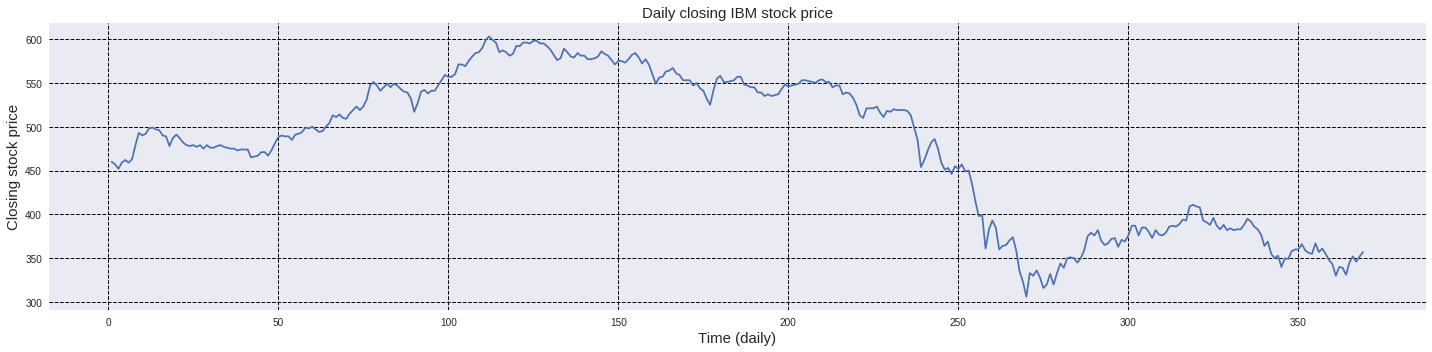

In [408]:
ts_ibmclose = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/ibmclose.csv", index_col = "Unnamed: 0")
ts_ibmclose.rename(columns={'x': 'value'}, inplace = True)

# plotting the data
plot_time_series(ts_ibmclose, xlabel = "Time (daily)", ylabel = "Closing stock price", title = "Daily closing IBM stock price")

**11.1 Splitting the data into training and testing set**

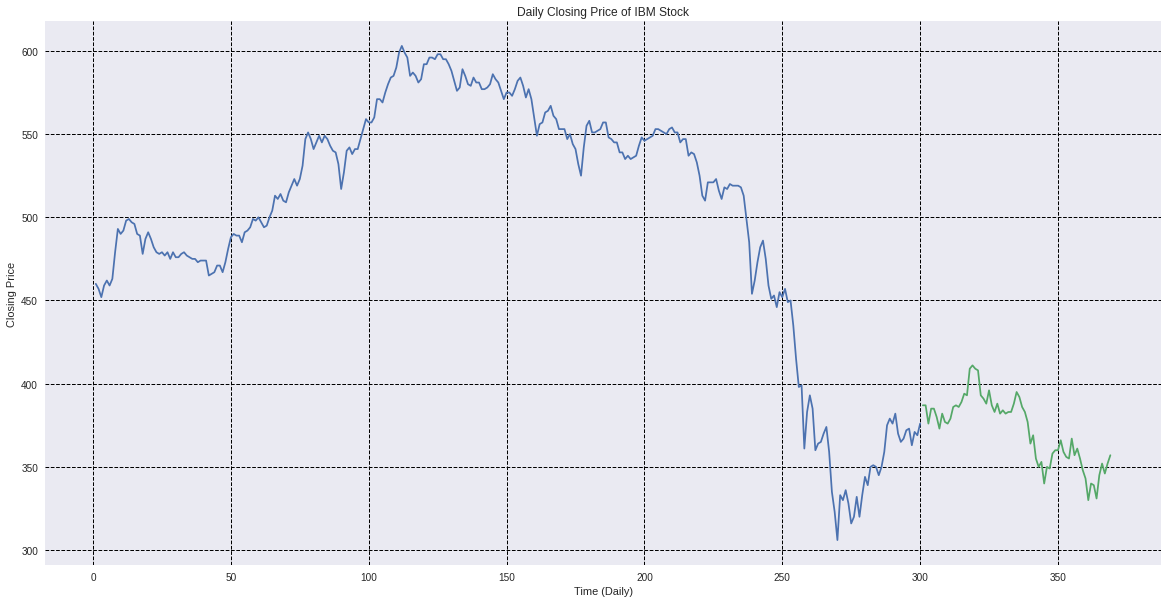

In [409]:
pivot = 300

ts_ibmclose_training = ts_ibmclose.loc[:pivot, :]
ts_ibmclose_testing = ts_ibmclose.loc[pivot+1:, :]

# plotting the training and testing data
plt.figure(figsize = (20, 10))
plt.plot(ts_ibmclose_training, label = "Training Data")
plt.plot(ts_ibmclose_testing, label = "Testing Data")
plt.xlabel("Time (Daily)")
plt.ylabel("Closing Price")
plt.title("Daily Closing Price of IBM Stock")
plt.grid(linestyle = "--", color = "black")
plt.show()

**11.2 Benchmark Methods on Training Data**

**11.2.1 Average Method**

In [410]:
ts_ibmclose_avg_forecasts = ts_ibmclose_testing.copy()

ts_ibmclose_avg_forecasts['value'] = np.mean(ts_ibmclose_training.values)

# computing the accuracy on the testing set
average_MAE, average_RMSE, average_MAPE = accuracy(ts_ibmclose_testing, ts_ibmclose_avg_forecasts)

**11.2.2 Drift Method**

In [411]:
horizon_start = ts_ibmclose_testing.index[0]
horizon_end = ts_ibmclose_testing.index[-1]

ts_ibmclose_drift_forecasts = drift_forecast(ts_ibmclose_training, horizon_start, horizon_end)

# computing the accuracy on the testing set
drift_MAE, drift_RMSE, drift_MAPE = accuracy(ts_ibmclose_testing, ts_ibmclose_drift_forecasts)

**11.2.3 Naive Method**

In [412]:
ts_ibmclose_naive_forecasts = s_naive_forecast(ts_ibmclose_training, 1, horizon_start, horizon_end)
ts_ibmclose_naive_forecasts.rename(columns = {0: 'value'}, inplace = True)

# computing the accuracy on the testing set
naive_MAE, naive_RMSE, naive_MAPE = accuracy(ts_ibmclose_testing, ts_ibmclose_naive_forecasts)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


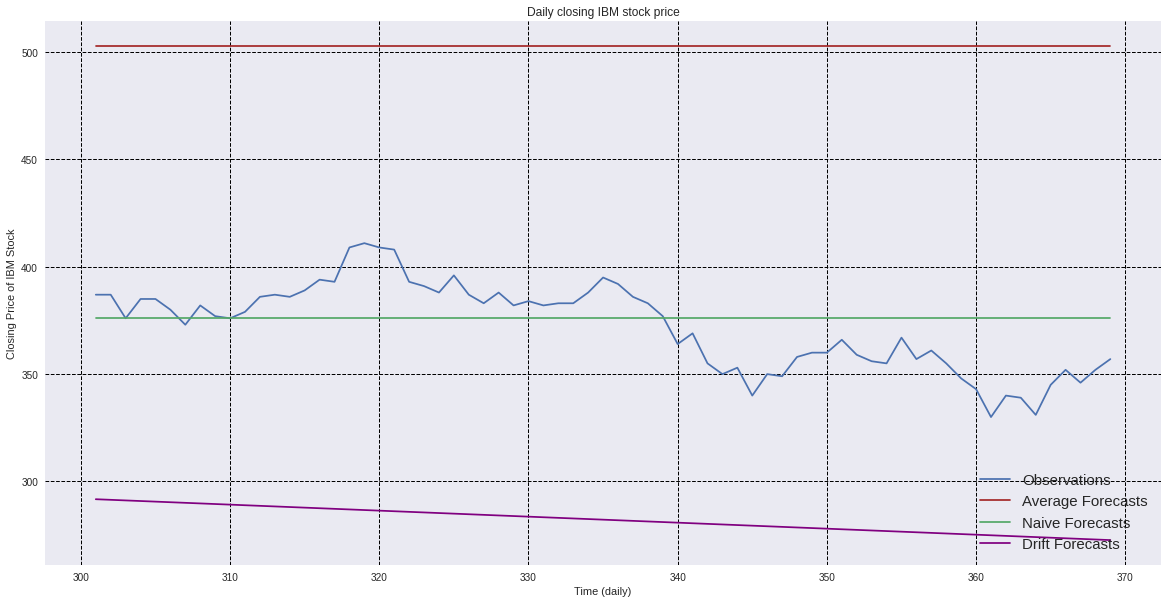

In [413]:
# plotting the testing set along with average, drift and naive forecast
plt.figure(figsize = (20, 10))
plt.plot(ts_ibmclose_testing, label = "Observations")
plt.plot(ts_ibmclose_avg_forecasts, label = "Average Forecasts", color = 'brown')
plt.plot(ts_ibmclose_naive_forecasts, label = "Naive Forecasts")
plt.plot(ts_ibmclose_drift_forecasts, label = "Drift Forecasts", color = 'purple')
plt.xlabel("Time (daily)")
plt.ylabel("Closing Price of IBM Stock")
plt.title("Daily closing IBM stock price")
plt.grid(linestyle = '--', color = 'black')
plt.legend(fontsize = 15)
plt.show()

**11.2.4 Checking Accuracy**

In [414]:
methods = ['average', 'naive', 'drift']
metrics = ['MAE', "RMSE", "MAPE"]

accuracy_score = pd.DataFrame(index = metrics, columns=methods)

accuracy_score['average'] = [average_MAE.value, average_RMSE.value, average_MAPE.value]
accuracy_score['naive'] = [naive_MAE.value, naive_RMSE.value, naive_MAPE.value]
accuracy_score['drift'] = [drift_MAE.value, drift_RMSE.value, drift_MAPE.value]

accuracy_score

,average,naive,drift
MAE,130.617971,17.028986,90.237647
RMSE,132.125573,20.248099,91.646592
MAPE,35.478819,4.668186,24.062959


**Conclusion: Naive is the best fit method on the testing set and hence the prefered method**

# Question: 12

Consider the sales of new one-family houses in the USA, Jan 1973 – Nov 1995 (data set hsales).

* Produce some plots of the data in order to become familiar with it.
* Split the hsales data set into a training set and a test set, where the test set is the last two years of data.
* Try using various benchmark methods to forecast the training set and compare the results on the test set. Which method did best?
* Check the residuals of your preferred method. Do they resemble white noise?

(<Figure size 1440x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8f9ee835f8>)

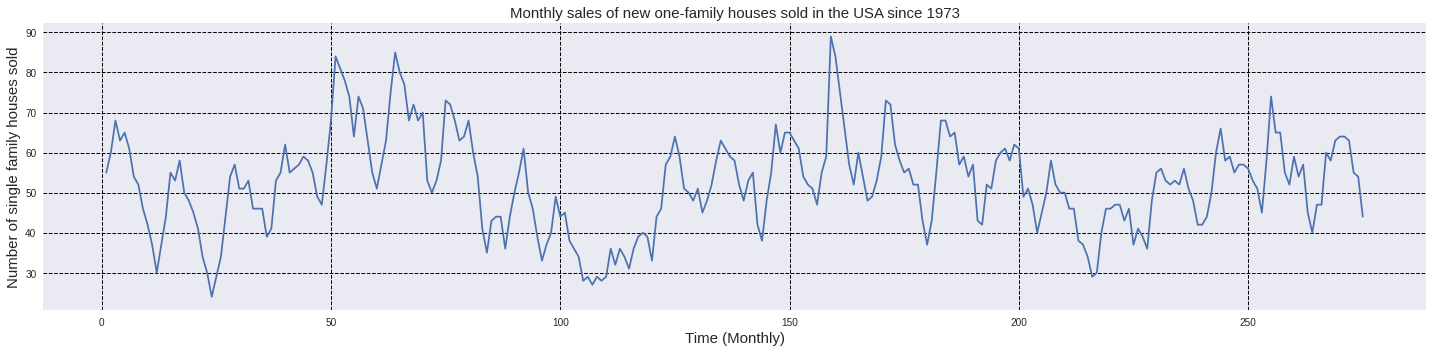

In [415]:
ts_hsales = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Time Series Analysis/Data/hsales.csv", index_col = "Unnamed: 0")
ts_hsales.rename(columns = {'x': 'value'}, inplace = True)
# plotting the time series plot
plot_time_series(ts_hsales, xlabel = "Time (Monthly)", ylabel = "Number of single family houses sold", title = "Monthly sales of new one-family houses sold in the USA since 1973")

**12.1 Splitting the data into training and testing set**

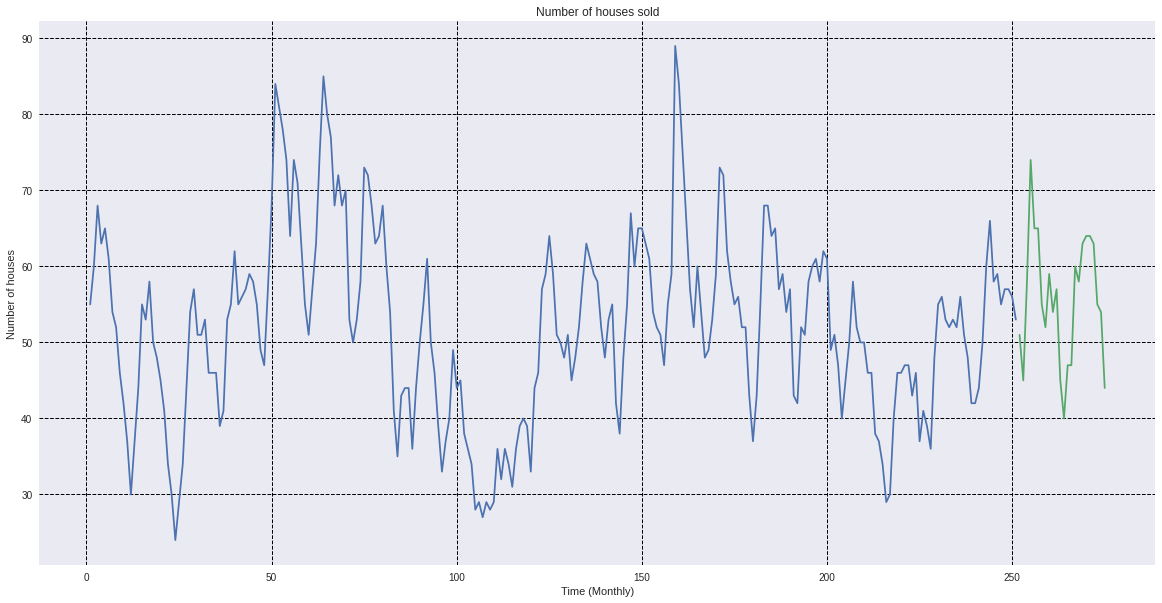

In [416]:
seasonal_period = 12  # monthly data

ts_hsales_training = ts_hsales.iloc[:-(2*seasonal_period), :]
ts_hsales_testing = ts_hsales.iloc[len(ts_hsales)-(2*seasonal_period):, :]

# plotting the training and testing set
plt.figure(figsize = (20, 10))
plt.plot(ts_hsales_training, label = "Training Data")
plt.plot(ts_hsales_testing, label = "Testing Data")
plt.xlabel("Time (Monthly)")
plt.ylabel("Number of houses")
plt.title("Number of houses sold")
plt.grid(linestyle = "--", color = "black")
plt.show()

**12.2 Benchmarking Methods on the Data**

**12.2.1 Average Method**

In [417]:
ts_hsales_avg_forecasts = ts_hsales_testing.copy()

ts_hsales_avg_forecasts['value'] = np.mean(ts_hsales_training.values)

# computing the accuracy of the forecasts on testing set
average_MAE, average_RMSE, average_MAPE = accuracy(ts_hsales_testing, ts_hsales_avg_forecasts)

**12.2.2 Drift Method**

In [418]:
horizon_start = ts_hsales_testing.index[0]
horizon_end = ts_hsales_testing.index[-1]

ts_hsales_drift_forecasts = drift_forecast(ts_hsales_training, horizon_start, horizon_end)

# computing the accuracy of the forecasts on testing set
drift_MAE, drift_RMSE, drift_MAPE = accuracy(ts_hsales_testing, ts_hsales_drift_forecasts)

**12.2.3 Seasoanl Naive**

In [419]:
ts_hsales_snaive_forecasts = s_naive_forecast(ts_hsales_training, seasonal_period+1, horizon_start, horizon_end+1)
ts_hsales_snaive_forecasts.drop([265], inplace = True)
ts_hsales_snaive_forecasts.set_index(ts_hsales_testing.index, inplace=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [424]:
ts_hsales_snaive_forecasts.rename(columns = {0: 'value'}, inplace = True)
snaive_MAE, snaive_RMSE, snaive_MAPE = accuracy(ts_hsales_testing, ts_hsales_snaive_forecasts)

**Performace Metrics on test set**

In [425]:
methods = ['average', 'naive', 'drift', 'snaive']
metrics = ['MAE', "RMSE", "MAPE"]

accuracy_score = pd.DataFrame(index = metrics, columns=methods)

accuracy_score['average'] = [average_MAE.value, average_RMSE.value, average_MAPE.value]
accuracy_score['naive'] = [naive_MAE.value, naive_RMSE.value, naive_MAPE.value]
accuracy_score['drift'] = [drift_MAE.value, drift_RMSE.value, drift_MAPE.value]
accuracy_score['snaive'] = [snaive_MAE.value, snaive_RMSE.value, drift_MAPE.value]

accuracy_score

,average,naive,drift,snaive
MAE,7.561587,17.028986,8.214447,4.791667
RMSE,9.022555,20.248099,9.697090,5.905506
MAPE,13.261827,4.668186,14.191957,14.191957


**Plotting all the methods along with training and testing set**

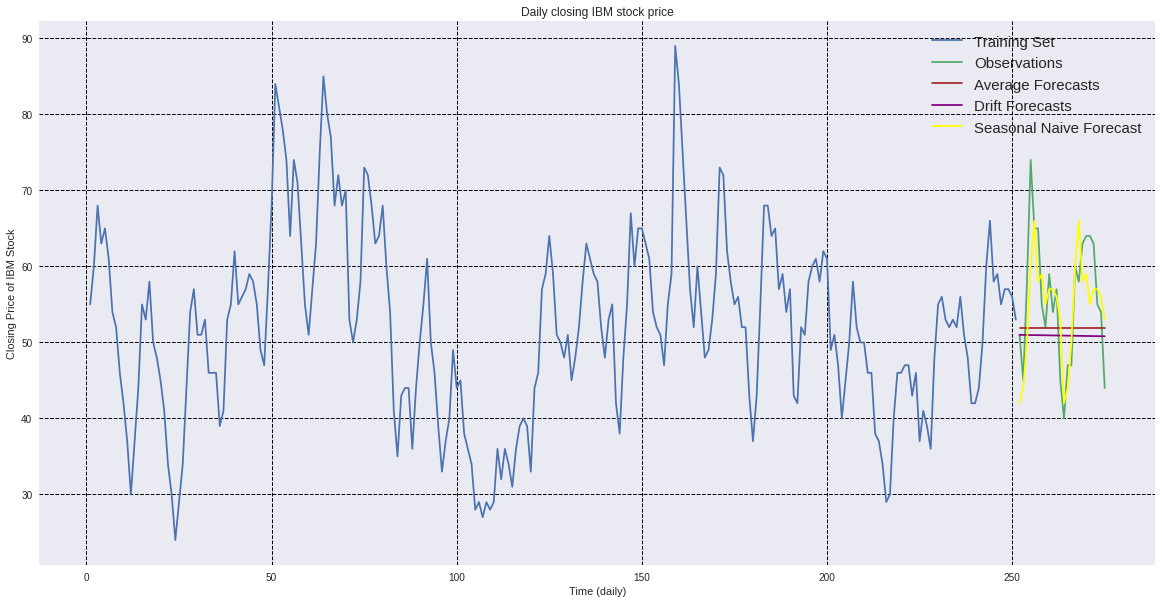

In [427]:
plt.figure(figsize = (20, 10))
plt.plot(ts_hsales_training, label = 'Training Set')
plt.plot(ts_hsales_testing, label = "Observations")
plt.plot(ts_hsales_avg_forecasts, label = "Average Forecasts", color = 'brown')
plt.plot(ts_hsales_drift_forecasts, label = "Drift Forecasts", color = 'purple')
plt.plot(ts_hsales_snaive_forecasts, label = "Seasonal Naive Forecast", color = 'yellow')
plt.xlabel("Time (daily)")
plt.ylabel("Closing Price of IBM Stock")
plt.title("Daily closing IBM stock price")
plt.grid(linestyle = '--', color = 'black')
plt.legend(fontsize = 15)
plt.show()